# Male Naive Vs Female CPH
1. Male CPH (baseline)
2. Male CPH (Week 7)

In [1]:
import os
import sys
sys.path.append("C:/Users/PC-EIAD209/Desktop/AnaKei/NIPD-AI")

#sys.path.append("C:\\Users\\"+os.getlogin()+"\\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\\PainClassifier")
from my_data_generator import *

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.io as sio
import os
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import h5py
import warnings
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from datetime import datetime
import scipy as sp
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import auc, roc_curve
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Conv3D, MaxPooling3D, Flatten, Dropout, GlobalAveragePooling3D, concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16
from keras.regularizers import l2
import cv2
from keras import initializers
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
import tensorflow as tf
from keras import losses
from tensorflow.keras.optimizers import SGD
import wandb
from wandb.integration.keras import WandbCallback
import gc
#from numba import cuda
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import nibabel as nib 
#from skiimage.transform import resize
#rabies_ref_path = r"F:/rabies/preprocess_batch-001/commonspace_bold/_scan_info_subject_id003.session01_split_name_sub-003_ses-01_desc-o_T2w/_run_None/sub-003_ses-01_task-rest_desc-oa_bold_autobox_combined.nii.gz"


In [3]:

rabies_ref_path= r"F:\New data\sigma_files\sigma_files\SIGMA_resam_InVivo_Brain_Template_Masked.nii"
rabies_vol = nib.load(rabies_ref_path).get_fdata()
#rabies_vol= np.mean(rabies_ref, axis=3)
print("rabies_vol shape:",rabies_vol.shape)

rabies_vol shape: (48, 81, 48)


In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Devices:", tf.config.list_physical_devices())


Num GPUs Available:  1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
#mover a my data generator 
'''def filter_heatmap(heatmap, threshold=0.4):
    heatmap = heatmap.astype(np.float32)
    if np.max(heatmap) > 0:
        heatmap /= np.max(heatmap)  #normalizar entre 0 y 1
    heatmap[heatmap < threshold] = 0
    return heatmap
'''

def filter_heatmap(heatmap, threshold=0.6):
    """
    Filtra el heatmap para resaltar solo las regiones más activas
    y lo prepara en formato uint8 para OpenCV.
    """
    # Copia para no modificar el original
    filtered = np.copy(heatmap)

    # Normalizar a rango [0, 1]
    if np.max(filtered) > 1:
        filtered = filtered / 255.0

    # Aplicar threshold adaptativo
    dynamic_threshold = threshold * np.max(filtered)
    filtered[filtered < dynamic_threshold] = 0

    # Normalizar nuevamente entre 0–255
    filtered = 255 * filtered / np.max(filtered) if np.max(filtered) > 0 else filtered

    # ✅ Convertir a uint8 para compatibilidad con OpenCV
    filtered = np.uint8(filtered)

    return filtered


# Model

In [ ]:
def VGG16_3D(blocks):
        
    inputs = Input(shape=(42, 65, 29), name='input_layer')
    x = Reshape(target_shape=[42, 65, 29, 1], name='input_x_3d_volumes')(inputs)

    if blocks == 1:
        print("entra al 1")
        #batch_norm
        x = BatchNormalization()(x)
        # 1st Conv Block
        x = Conv3D(filters =64, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = Conv3D(filters =64, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        x = tf.keras.layers.GlobalAveragePooling3D()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        
    elif blocks == 2:
        print("entra al 2")
        #batch_norm
        x = BatchNormalization()(x)
        # 1st Conv Block
        x = Conv3D(filters =64, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = Conv3D(filters =64, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
            
        #batch_norm
        x = BatchNormalization()(x)
        # 2nd Conv Block
        x = Conv3D (filters =128, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = Conv3D (filters =128, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        x = tf.keras.layers.GlobalAveragePooling3D()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        
    elif blocks == 3:
        print("entra al 3")
        #batch_norm
        x = BatchNormalization()(x)
        # 1st Conv Block
        x = Conv3D(filters =64, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = Conv3D(filters =64, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
            
        #batch_norm
        x = BatchNormalization()(x)
        # 2nd Conv Block
        x = Conv3D (filters =128, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = Conv3D (filters =128, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        
        #batch_norm
        x = BatchNormalization()(x)
        # 3rd Conv block  
        x = Conv3D (filters =256, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x) 
        x = Conv3D (filters =256, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x) 
        x = Conv3D (filters =256, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x) 
        x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        x = tf.keras.layers.GlobalAveragePooling3D()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        
    elif blocks == 4:
        print("entra al 4")
        #batch_norm
        x = BatchNormalization()(x)
        # 1st Conv Block
        x = Conv3D(filters =64, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = Conv3D(filters =64, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
            
        #batch_norm
        x = BatchNormalization()(x)
        # 2nd Conv Block
        x = Conv3D (filters =128, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = Conv3D (filters =128, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        #x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        
        #batch_norm
        x = BatchNormalization()(x)
        # 3rd Conv block  
        x = Conv3D (filters =256, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x) 
        x = Conv3D (filters =256, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x) 
        x = Conv3D (filters =256, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x) 
        #x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        
        #batch_norm
        x = BatchNormalization()(x)
        # 4th Conv block
        x = Conv3D (filters =512, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = Conv3D (filters =512, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = Conv3D (filters =512, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        #x = tf.keras.layers.GlobalAveragePooling3D()(x)
        x = tf.keras.layers.Dropout(0.5)(x)

    elif blocks == 5:
        print("entra al 5")
        #batch_norm
        x = BatchNormalization()(x)
        # 1st Conv Block
        x = Conv3D(filters =64, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.05))(x)
        x = Conv3D(filters =64, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.05))(x)
        #x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        x = tf.keras.layers.Dropout(0.3)(x)
            
        #batch_norm
        x = BatchNormalization()(x)
        # 2nd Conv Block
        x = Conv3D (filters =128, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.05))(x)
        x = Conv3D (filters =128, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.05))(x)
        #x = MaxPooling3D(pool_size =2, strides =1, padding ='same')(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        
        #batch_norm
        x = BatchNormalization()(x)
        # 3rd Conv block  
        x = Conv3D (filters =256, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.05))(x) 
        x = Conv3D (filters =256, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.05))(x) 
        x = Conv3D (filters =256, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.05))(x) 
        #x = MaxPooling3D(pool_size =2, strides =1, padding ='same')(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        
        #batch_norm
        x = BatchNormalization()(x)
        # 4th Conv block
        x = Conv3D (filters =512, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.05))(x)
        x = Conv3D (filters =512, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.05))(x)
        x = Conv3D (filters =512, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.05))(x)
        #x = MaxPooling3D(pool_size =2, strides =1, padding ='same')(x)
        x = tf.keras.layers.Dropout(0.3)(x)
    
        #batch_norm
        x = BatchNormalization()(x)
        # 5th Conv block
        x = Conv3D (filters =512, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.05))(x)
        x = Conv3D (filters =512, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.05))(x)
        x = Conv3D (filters =512, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.05))(x)
        #x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        x = tf.keras.layers.GlobalAveragePooling3D()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
    
    # Fully connected layers  
    x = Flatten()(x) 
    x = Dense(units = 4096, activation ='relu',kernel_regularizer='l2')(x)
    #x = tf.keras.layers.Dropout(0.5)(x)
    x = Dense(units = 4096, activation ='relu',kernel_regularizer='l2')(x) 
    x = tf.keras.layers.Dropout(0.5)(x)
    output = Dense(units = 2,activation ='sigmoid',kernel_regularizer='l2')(x)
    
    # creating the model
    VGG_3d_model = Model (inputs=inputs, outputs =output)
    #model.summary()

    return VGG_3d_model

def set_pretrained_weigths(VGG_3d_model):
    #VGG 16 with weights from Imagenet
    pretrained_model = tf.keras.applications.VGG16(
        include_top=False,
        weights="imagenet",
        pooling='avg',
        input_shape = (42, 65, 3)
    )
    
    #conv layers on VGG_3d_model
    layers_conv = []
    for j in range(len(VGG_3d_model.layers)):
        if "conv3d" in str(VGG_3d_model.layers[j]):
            layers_conv.append(j)
    layers_conv_pretrained = []
    for j in range(len(pretrained_model.layers)):
        if "Conv2D" in str(pretrained_model.layers[j]):
            layers_conv_pretrained.append(j)
    
    for i in range(len(layers_conv)):
        if "Conv2D" in str(pretrained_model.layers[layers_conv_pretrained[i]]):
            if i == 0:
                w = pretrained_model.layers[layers_conv_pretrained[i]].get_weights()[0].sum(axis=2, keepdims=True)
            else:
                w = pretrained_model.layers[layers_conv_pretrained[i]].get_weights()[0]
                
            w3d=[]
            
            w = np.reshape(w,(3,3,-1),order='F')
            for j in range(len(w[0,0,:])):
                for k in range(3):
                    w3d.append(w[:,:,j])
            w3d = np.transpose(w3d, (1,2,0))
            
            new_weights = np.reshape(w3d, np.array(VGG_3d_model.layers[layers_conv[i]].get_weights()[0]).shape,order='F')
            new_bias = pretrained_model.layers[layers_conv_pretrained[i]].get_weights()[1]
            
            WnB = []
            WnB.append(new_weights)
            WnB.append(new_bias)
    
            VGG_3d_model.layers[layers_conv[i]].set_weights(WnB)

    del pretrained_model, w, WnB, new_weights, new_bias, w3d

# Metrics

In [ ]:
def confusionmatrix_multiclass(y_test,pred):
    cm = confusion_matrix(y_test, (np.rint(preds)).astype(int) )
    group_names = ['True baseline','False Baseline','False Baseline',   
                   'False week 1','Truec','False Week 1',
                  'False week 7','False week 7','True week 7']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         np.ndarray.flatten(cm/(np.sum(cm,axis=1).reshape(3,1)))]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(3,3)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels = ['Baseline','Week 1','Week 7'] ,yticklabels = ['Baseline','Week 1','Week 7'])
    plt.show()

def confusionmatrix(y_test,preds):
    #Construct the Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    group_names = ['True Naive','False Naive','False CPH','True CPH']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         np.ndarray.flatten(cm/(np.sum(cm,axis=1).reshape(2,1)))]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels = ['BL','W7'] ,yticklabels = ['BL','W7'])
    plt.show()
    return sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels = ['BL','W7'] ,yticklabels = ['BL','W7'])
    
def confusionmatrix_binary(y_test, preds):
    cm = confusion_matrix(y_test, preds)
    group_names = ['True baseline','False baseline','False Week 1','True Week 1']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         np.ndarray.flatten(cm/(np.sum(cm,axis=1).reshape(2,1)))]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels = ['BL','W7'] ,yticklabels = ['BL','W7'])
    plt.show()

def ROC(probs,y_test): #binary
    #Classification Area under curve
     warnings.filterwarnings('ignore')
             
     auc = roc_auc_score(y_test, probs)
     print('AUC - Test Set: %.2f%%' % (auc*100))
    
     # calculate roc curve
     fpr, tpr, thresholds = roc_curve(y_test, probs)
     # plot no skill
     plt.plot([0, 1], [0, 1], linestyle='--')
     # plot the roc curve for the model
     plt.plot(fpr, tpr, marker='.')
     plt.xlabel('False positive rate')
     plt.ylabel('Sensitivity/ Recall')
     # show the plot
     plt.show()
    
     probs = (np.rint(probs)).astype(int)   
        
     precision = precision_score(y_test, probs)
     print('Precision: %f' % precision)
     # recall: tp / (tp + fn)
     recall = recall_score(y_test, probs)
     print('Recall: %f' % recall)
     # f1: tp / (tp + fp + fn)
     f1 = f1_score(y_test, probs)
     print('F1 score: %f' % f1)
        
def ROC_multiclass(model, y_test, n_class):
    #y_test: array size (# of subjects, ) with classes 
    #pretrained model to be evaluated 
    
    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)
    y_onehot_test.shape  # (n_samples, n_classes)

    y_score = model.predict(X_test) # y_score is onehot
    
    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")
    
    n_classes = n_class
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")
    
    target_names = ['Naive','Week1','Week7']

    fig, ax = plt.subplots(figsize=(6, 6))

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {target_names[class_id]}",
            color=color,
            ax=ax,
            plot_chance_level=(class_id == 2),
        )

    _ = ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
    )
    
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    c = ['b','g','r','c','m','y','k','w']
    ltr = ['fold 1(train)','fold 2(train)','fold 3(train)','fold 4(train)','fold 5(train)']
    lts = ['fold 1(val)','fold 2(val)','fold 3(val)','fold 4(val)','fold 5(val)']
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color=c[i], label=ltr[i], linestyle="-")
        plt.plot(histories[i].history['val_loss'], color=c[i], label=lts[i], linestyle="--")
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['Accuracy'], color=c[i], label=ltr[i], linestyle="-")
        plt.plot(histories[i].history['val_Accuracy'], color=c[i], label=lts[i], linestyle="--")
    plt.legend()
    plt.show()

# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show() 

# Just brain. Female. Naive vs CPH
1) Naive (CPH_BL)
2) CPH (CPH_W7)

In [8]:
#female = [49,50,51,52,65,66,77,78,79,80,81,82,83]
male = [57, 
        #59,
        60,73,74,93,94,95,96,98,99,100]
y_male=np.ones(len(male))
#female=[49,50,51,52,65,66,77,78,79]
#y_female = np.ones(len(female))

subjects = np.array(male)
labels = np.array(list(y_male))
sessions = [1,3]
MRI_type = "func"
functional_type = "rest"

In [9]:
wandb.login()

wandb: Currently logged in as: a01067716 (a01067716-tecnol-gico-de-monterrey) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [10]:
import os
base_path = r"C:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\treasured-wood-61"
for root, dirs, files in os.walk(base_path):
    for f in files:
        if "GradCam" in f:
            print(os.path.join(root, f))


C:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\treasured-wood-61\CPH\Array_GradCam-CPH.npy
C:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\treasured-wood-61\CPH\GradCam_CPH(BlVsW1-CPH).mp4
C:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\treasured-wood-61\Naive\Array_GradCam-Naive.npy
C:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\treasured-wood-61\Naive\GradCam_Naive(BlVsW1-CPH).mp4


In [11]:
import sys
print (sys.executable)

c:\Users\PC-EIAD209\.conda\envs\nipd\python.exe


In [12]:
import matplotlib.animation as animation
print(animation.writers.list())

['pillow', 'ffmpeg', 'ffmpeg_file', 'html']



=== Bootstrapping Run 1/1 ===
Run # 1


sub train:
['F:/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id074.session01_split_name_sub-074_ses-01_desc-o_T2w/_run_None/sub-074_ses-01_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'F:/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id093.session01_split_name_sub-093_ses-01_desc-o_T2w/_run_None/sub-093_ses-01_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'F:/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id095.session01_split_name_sub-095_ses-01_desc-o_T2w/_run_None/sub-095_ses-01_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'F:/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id095.session01_split_name_sub-095_ses-01_desc-o_T2w/_run_None/sub-095_ses-01_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'F:/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id074.session03_split_name_sub-074_ses-03_des

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Epoch 1/10
152/152 [==============================] - ETA: 0s - loss: 63.8266 - Accuracy: 0.5252 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\true-hill-3\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\true-hill-3\assets


152/152 [==============================] - 2045s 14s/step - loss: 63.8266 - Accuracy: 0.5252 - val_loss: 60.5950 - val_Accuracy: 0.5000 - combine_metric: 0.0083
Epoch 2/10
152/152 [==============================] - ETA: 0s - loss: 57.4180 - Accuracy: 0.5219 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\true-hill-3\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\true-hill-3\assets


152/152 [==============================] - 2102s 14s/step - loss: 57.4180 - Accuracy: 0.5219 - val_loss: 54.2664 - val_Accuracy: 0.5000 - combine_metric: 0.0092
Epoch 3/10
152/152 [==============================] - ETA: 0s - loss: 51.3449 - Accuracy: 0.5329 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\true-hill-3\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\true-hill-3\assets


152/152 [==============================] - 1812s 12s/step - loss: 51.3449 - Accuracy: 0.5329 - val_loss: 48.6186 - val_Accuracy: 0.5000 - combine_metric: 0.0103
Epoch 4/10
152/152 [==============================] - ETA: 0s - loss: 46.0278 - Accuracy: 0.7711 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\true-hill-3\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\true-hill-3\assets


152/152 [==============================] - 1866s 12s/step - loss: 46.0278 - Accuracy: 0.7711 - val_loss: 44.2263 - val_Accuracy: 0.4965 - combine_metric: 0.0112
Epoch 5/10
152/152 [==============================] - 2078s 14s/step - loss: 41.6703 - Accuracy: 0.9783 - val_loss: 40.3536 - val_Accuracy: 0.2860 - combine_metric: 0.0071
Epoch 6/10
152/152 [==============================] - ETA: 0s - loss: 37.9037 - Accuracy: 0.9932 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\true-hill-3\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\true-hill-3\assets


152/152 [==============================] - 1850s 12s/step - loss: 37.9037 - Accuracy: 0.9932 - val_loss: 36.6826 - val_Accuracy: 0.5000 - combine_metric: 0.0136
Epoch 7/10
152/152 [==============================] - ETA: 0s - loss: 34.4689 - Accuracy: 0.9958 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\true-hill-3\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\true-hill-3\assets


152/152 [==============================] - 2017s 13s/step - loss: 34.4689 - Accuracy: 0.9958 - val_loss: 33.3591 - val_Accuracy: 0.5000 - combine_metric: 0.0150
Epoch 8/10
152/152 [==============================] - ETA: 0s - loss: 31.3383 - Accuracy: 0.9971 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\true-hill-3\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\true-hill-3\assets


152/152 [==============================] - 1958s 13s/step - loss: 31.3383 - Accuracy: 0.9971 - val_loss: 30.3670 - val_Accuracy: 0.5000 - combine_metric: 0.0165
Epoch 9/10
152/152 [==============================] - ETA: 0s - loss: 28.4934 - Accuracy: 0.9996 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\true-hill-3\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\true-hill-3\assets


152/152 [==============================] - 2176s 14s/step - loss: 28.4934 - Accuracy: 0.9996 - val_loss: 27.6674 - val_Accuracy: 0.5000 - combine_metric: 0.0181
Epoch 10/10
152/152 [==============================] - ETA: 0s - loss: 25.9286 - Accuracy: 0.9980 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\true-hill-3\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\true-hill-3\assets


152/152 [==============================] - 2011s 13s/step - loss: 25.9286 - Accuracy: 0.9980 - val_loss: 25.2230 - val_Accuracy: 0.5000 - combine_metric: 0.0198
Duration (CNN): 5:32:29.775571
Evaluating best epoch
114/114 [==============================] - 112s 983ms/step - loss: 25.2178 - Accuracy: 0.5000
predicts CNN
114/114 [==============================] - 87s 765ms/step
mislabeled subjects:
 Counter({'F:/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id073.session01_split_name_sub-073_ses-01_desc-o_T2w/_run_None/sub-073_ses-01_task-rest_desc-oa_bold_autobox_combined.nii.gz': 570, 'F:/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id099.session01_split_name_sub-099_ses-01_desc-o_T2w/_run_None/sub-099_ses-01_task-rest_desc-oa_bold_autobox_combined.nii.gz': 570, 'F:/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id096.session01_split_name_sub-096_ses-01_desc-o_T2w/_run_None/su

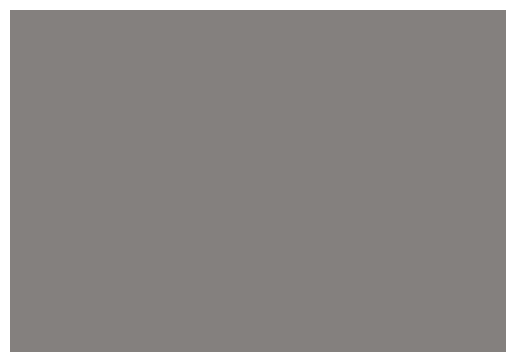

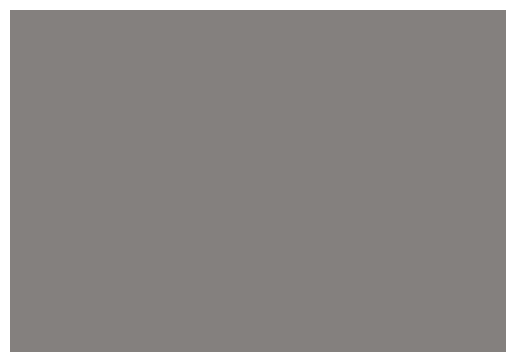

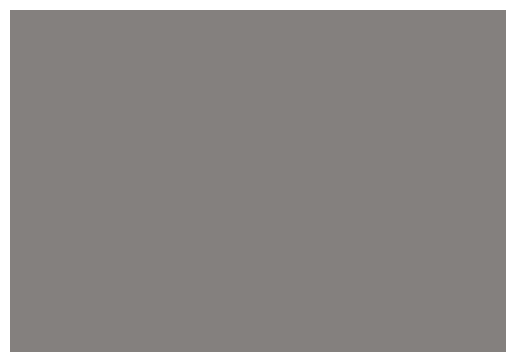

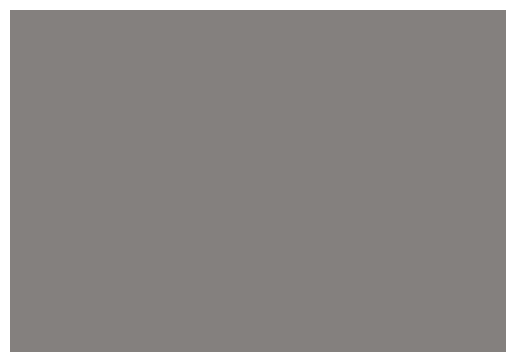

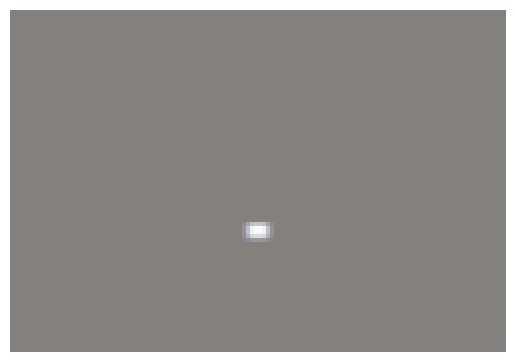

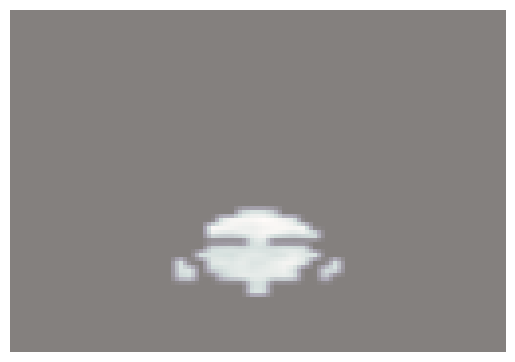

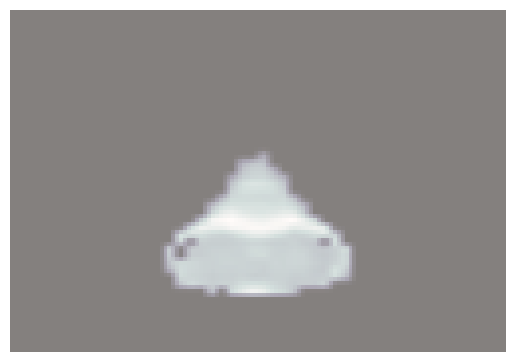

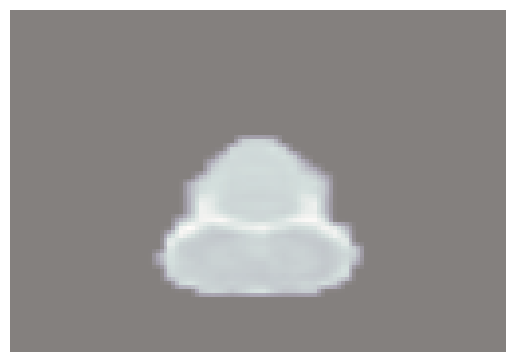

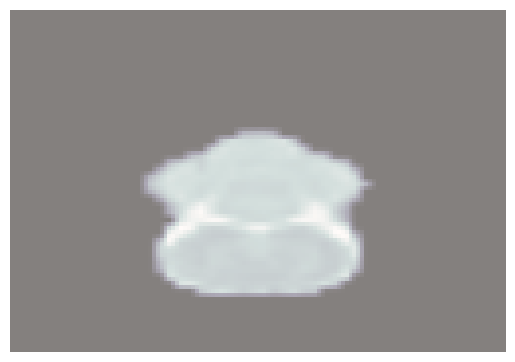

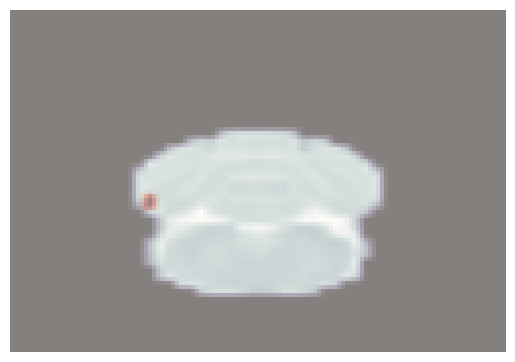

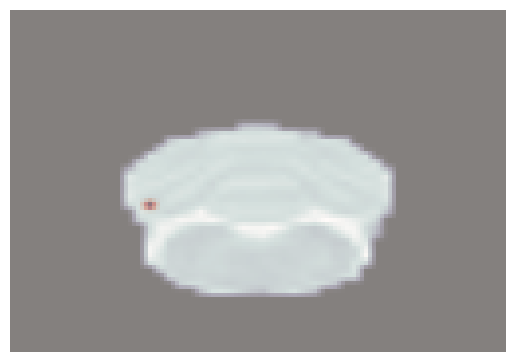

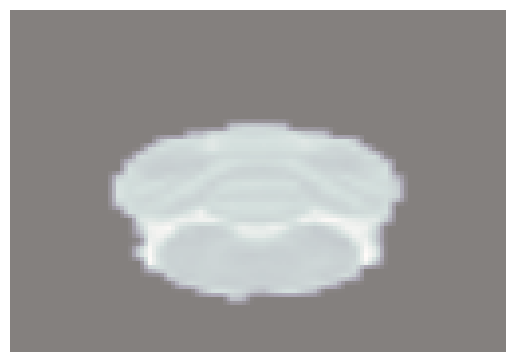

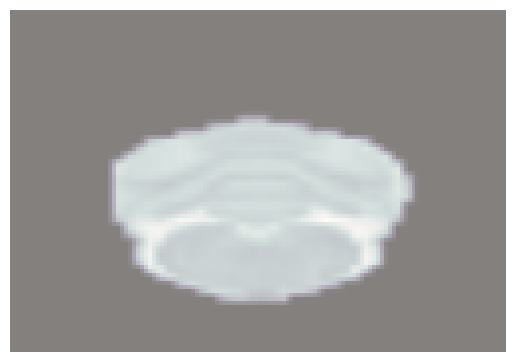

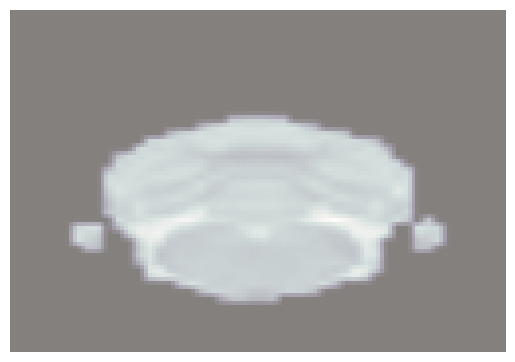

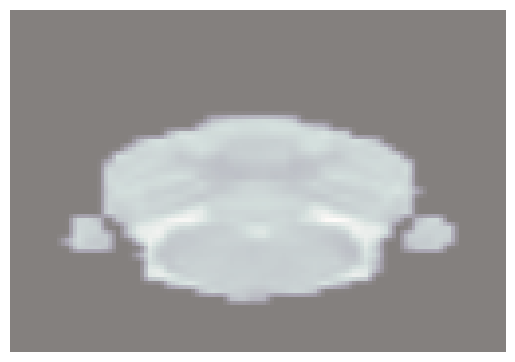

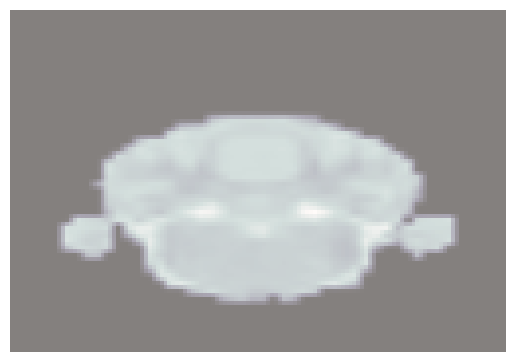

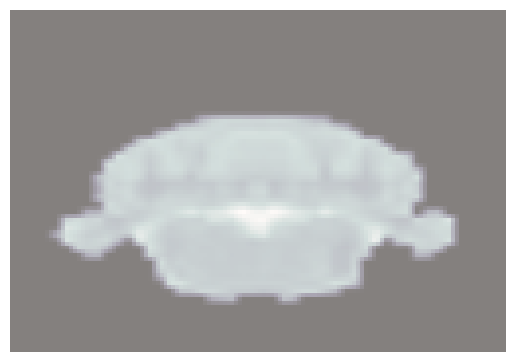

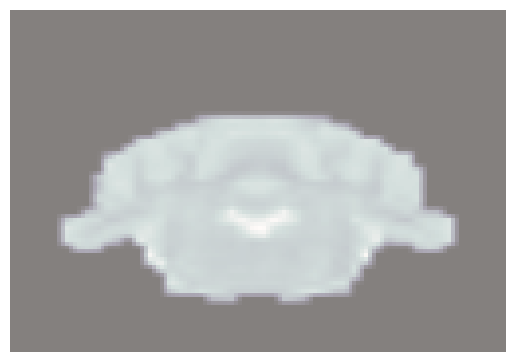

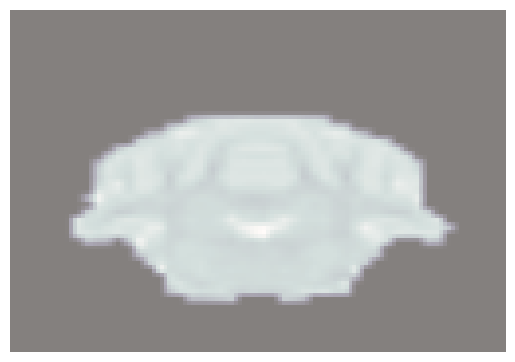

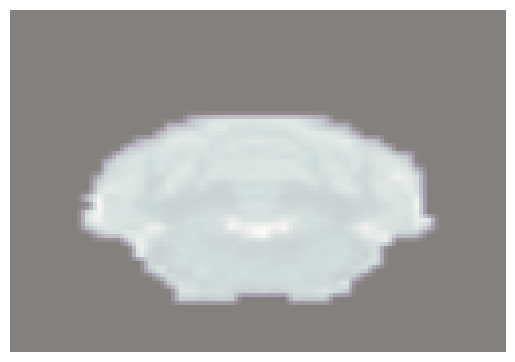

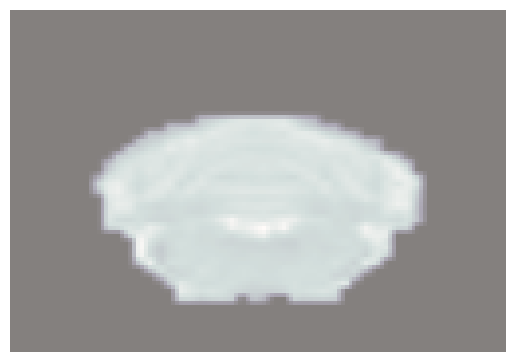

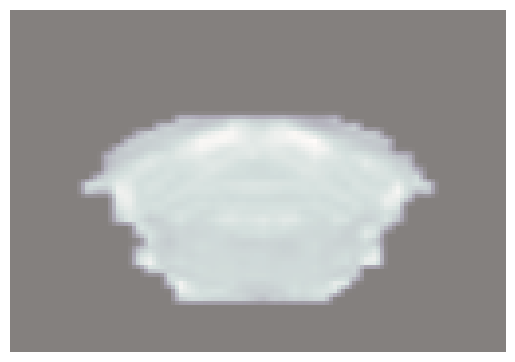

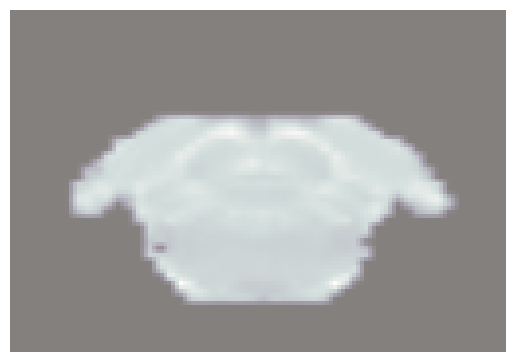

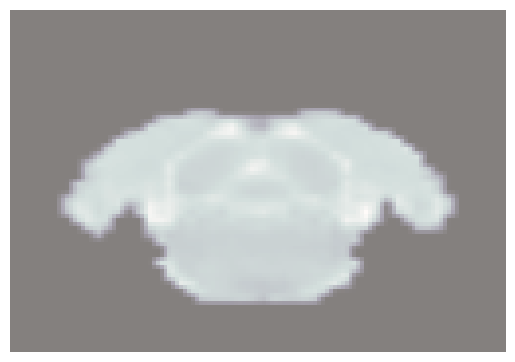

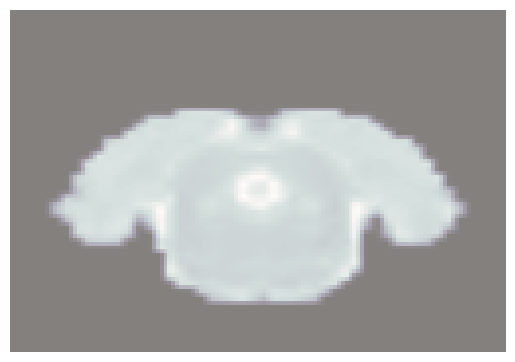

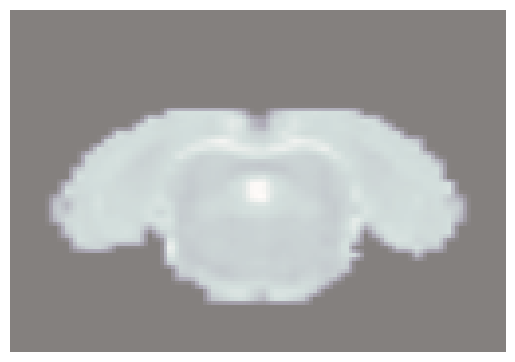

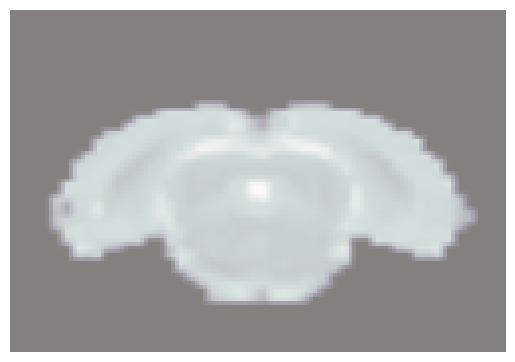

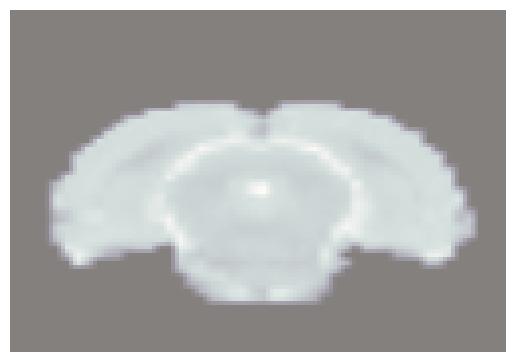

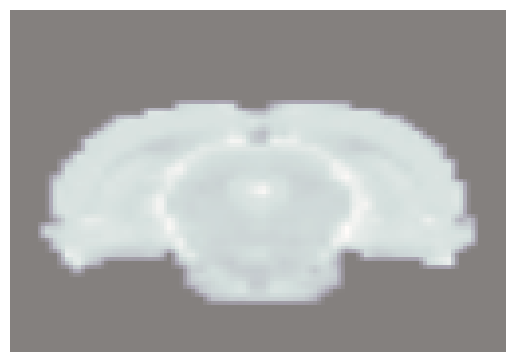

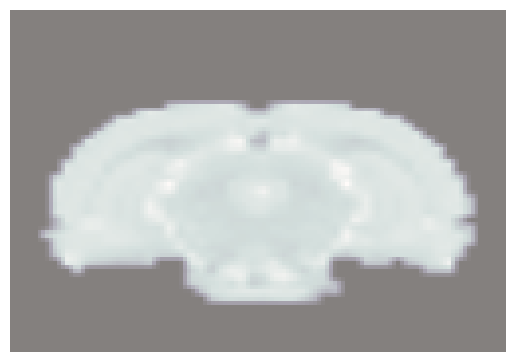

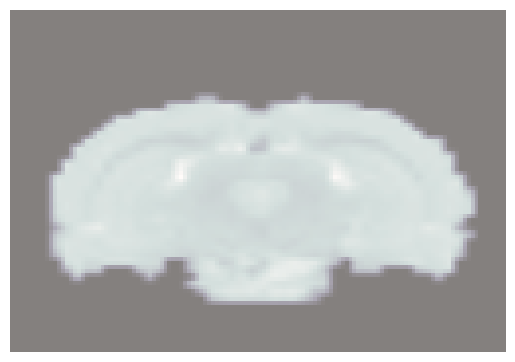

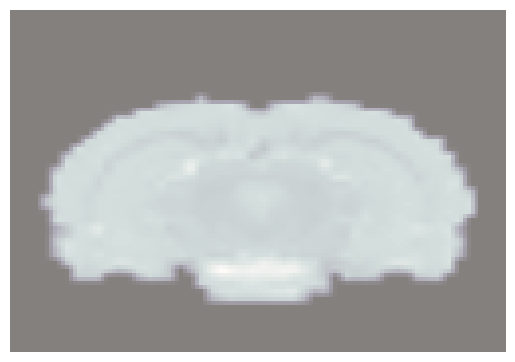

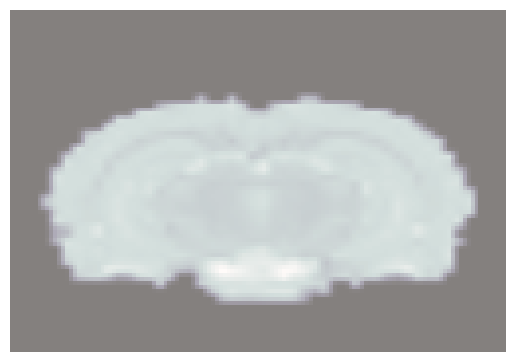

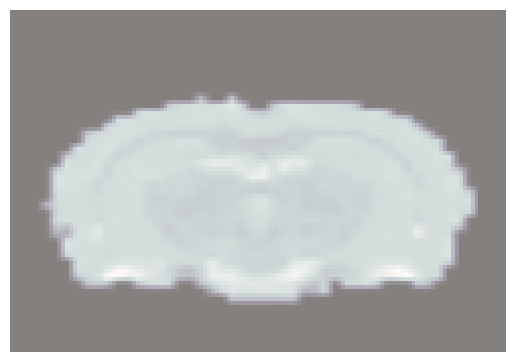

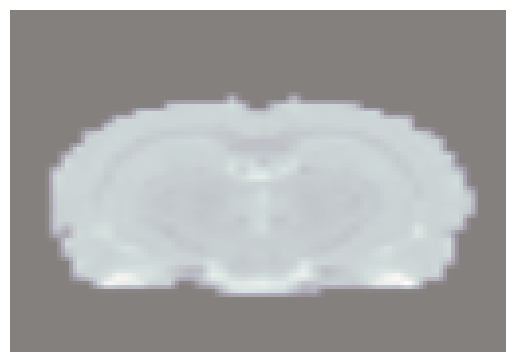

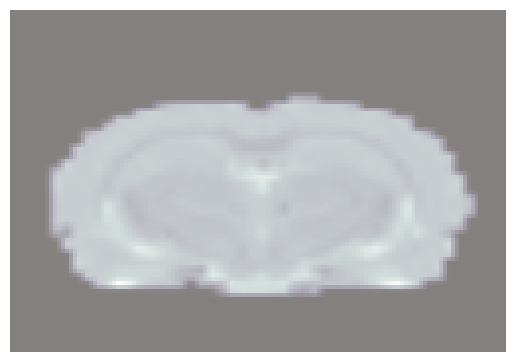

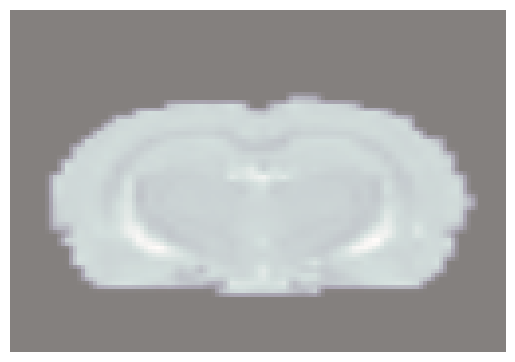

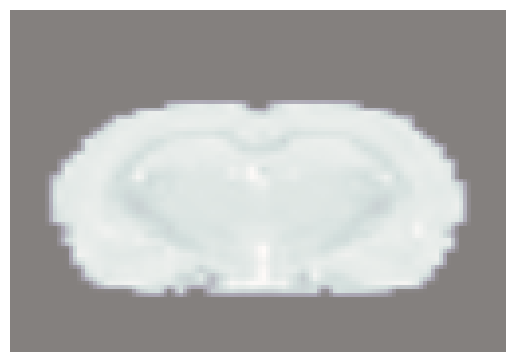

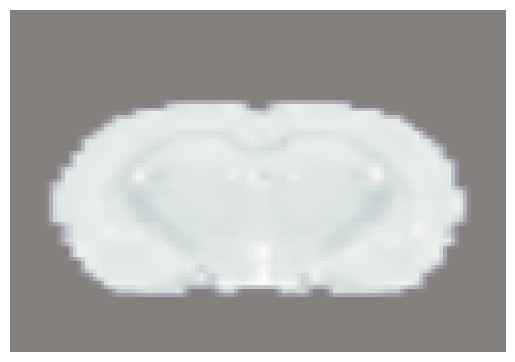

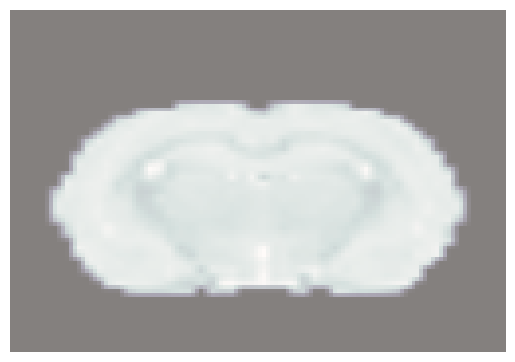

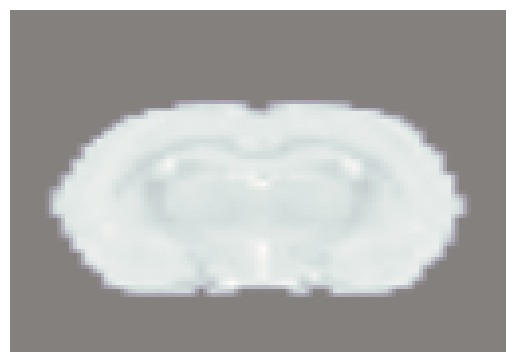

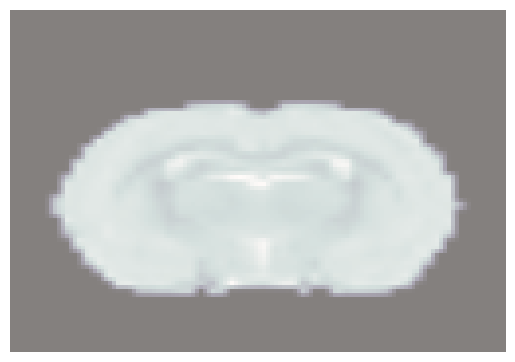

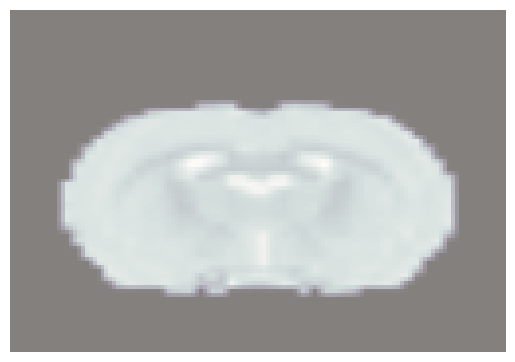

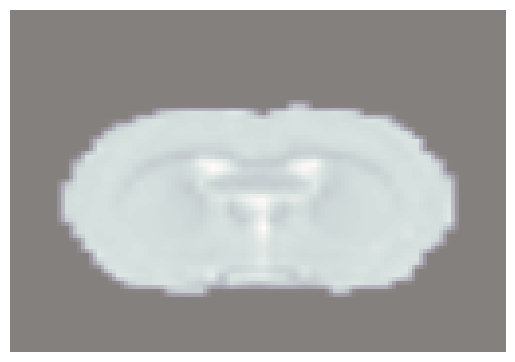

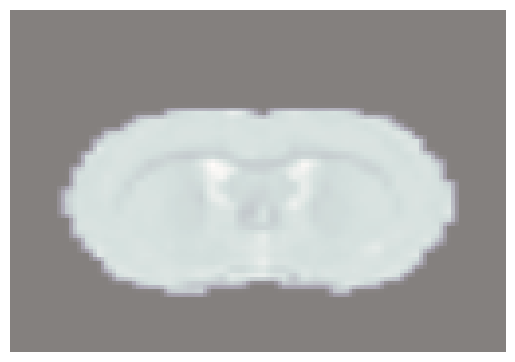

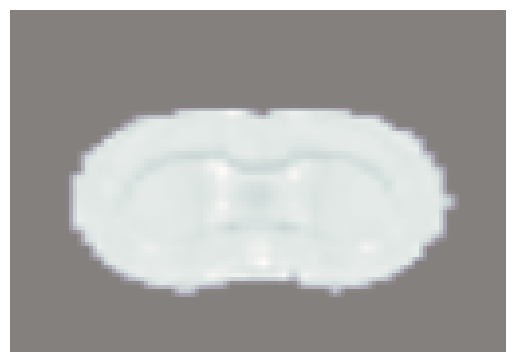

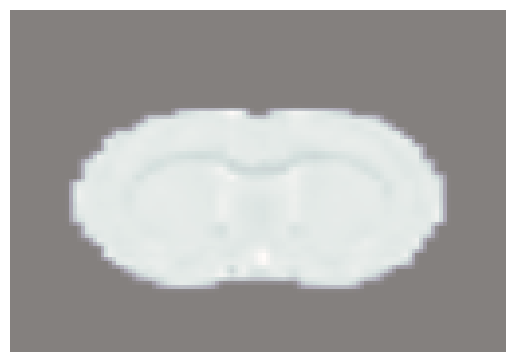

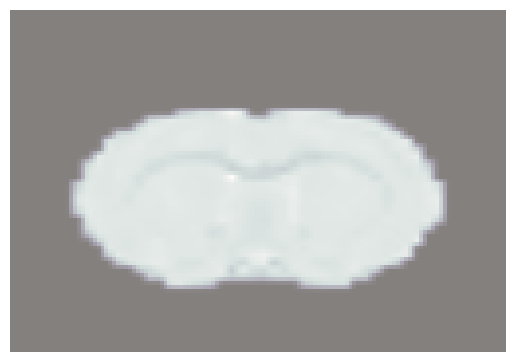

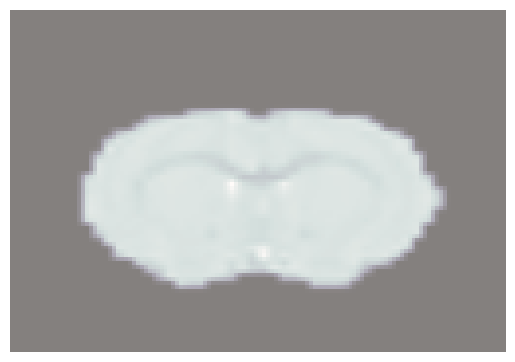

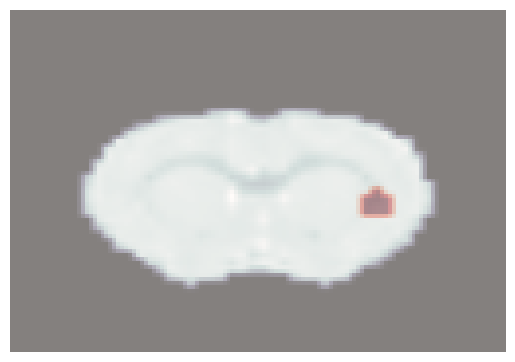

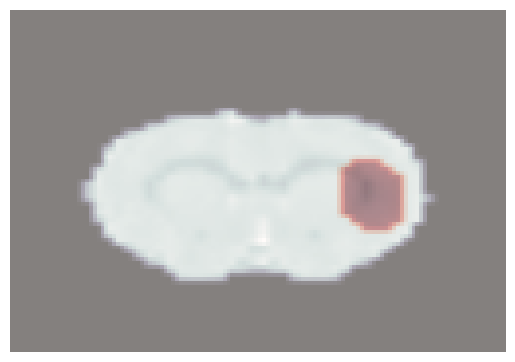

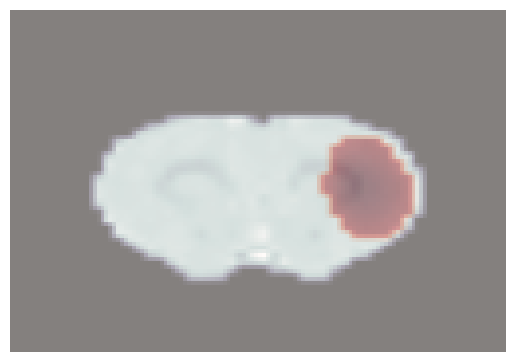

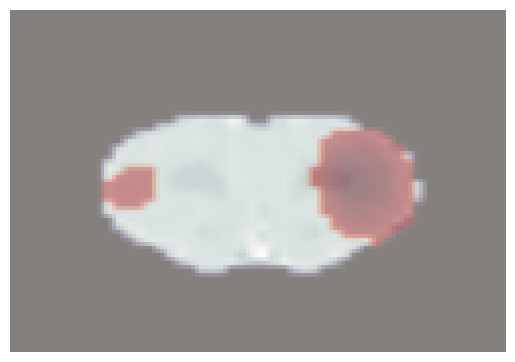

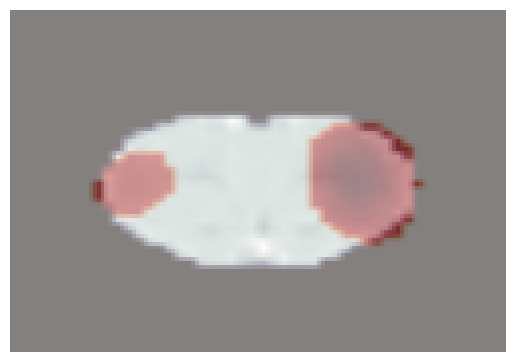

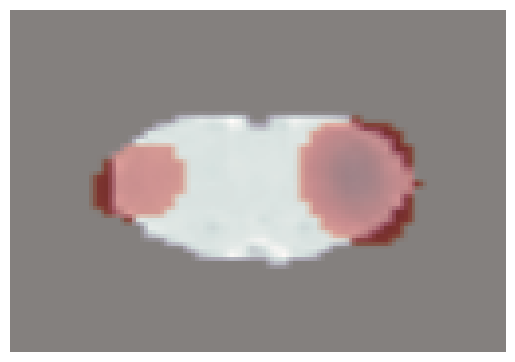

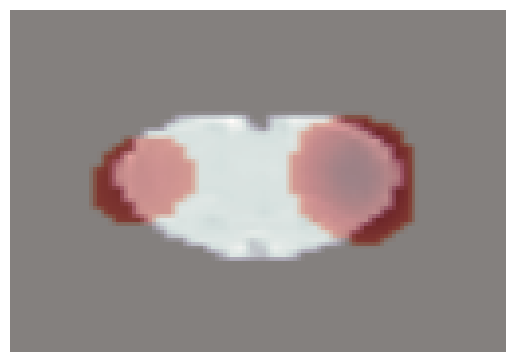

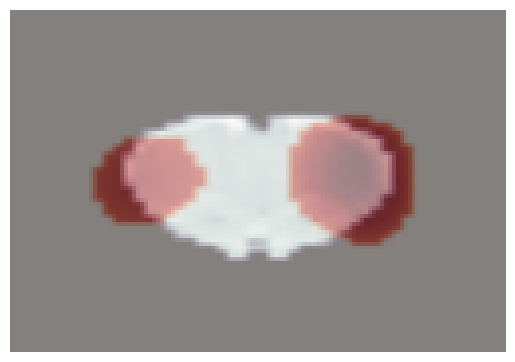

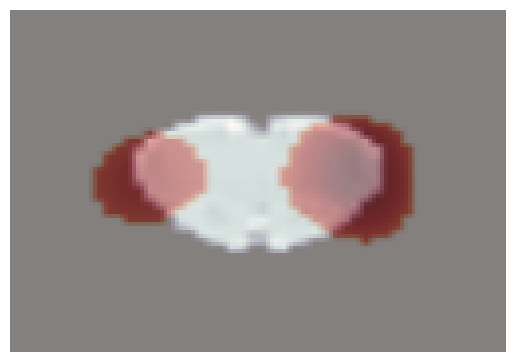

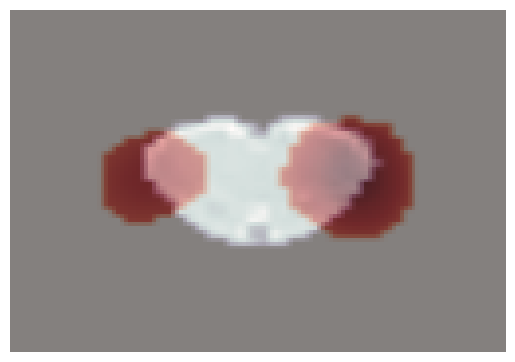

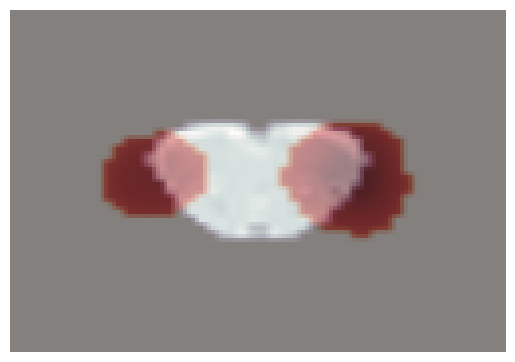

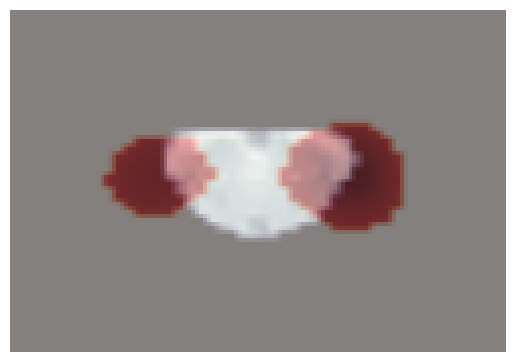

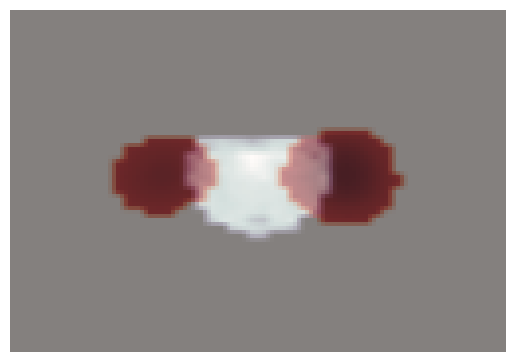

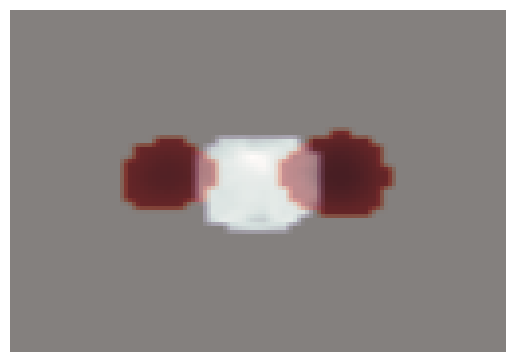

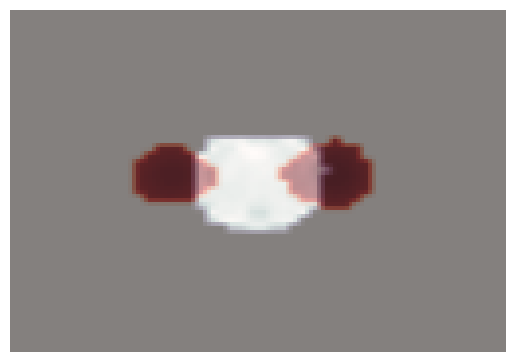

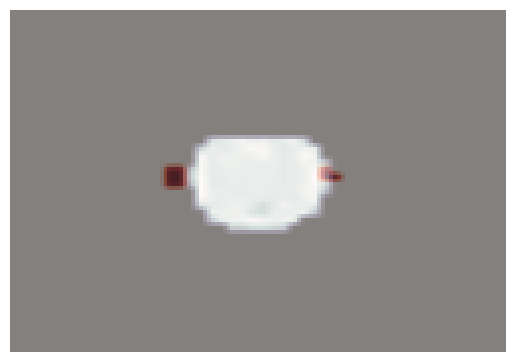

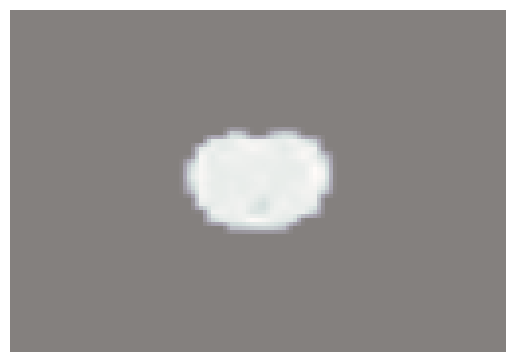

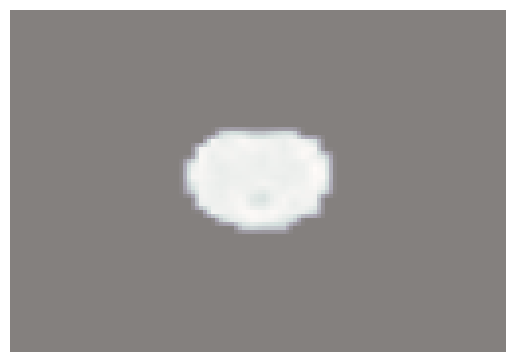

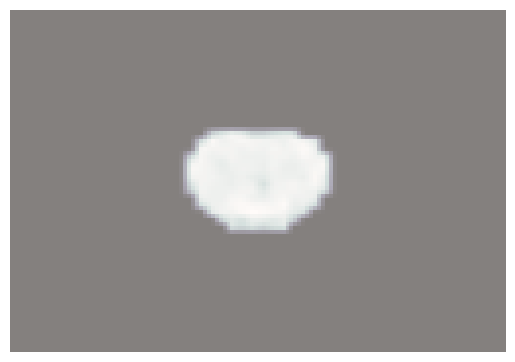

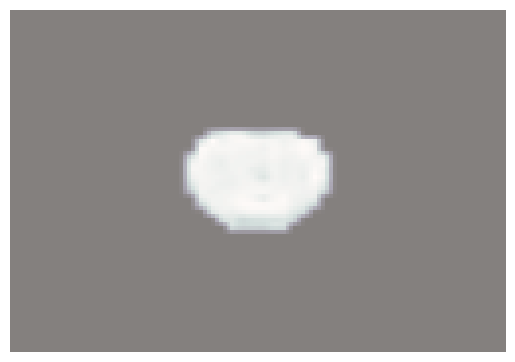

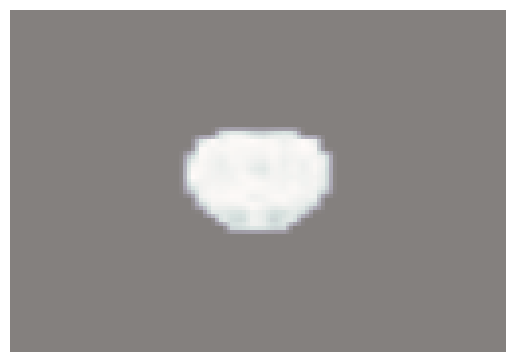

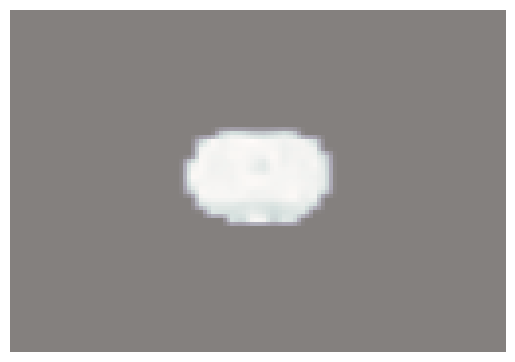

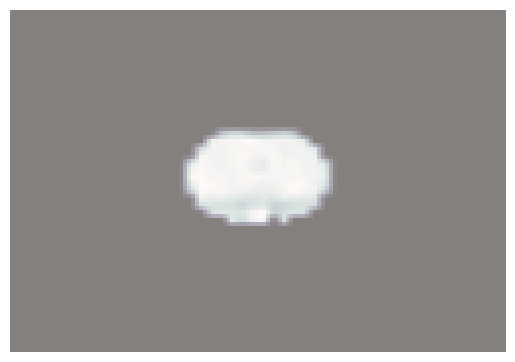

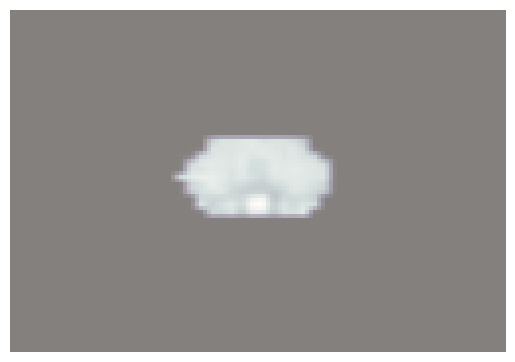

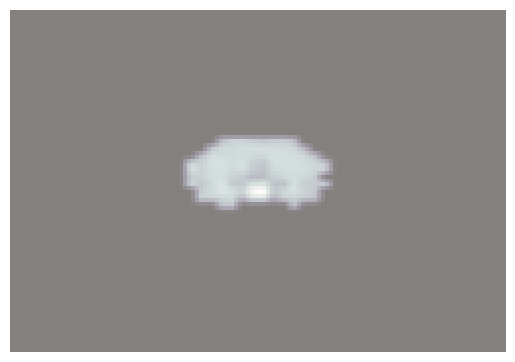

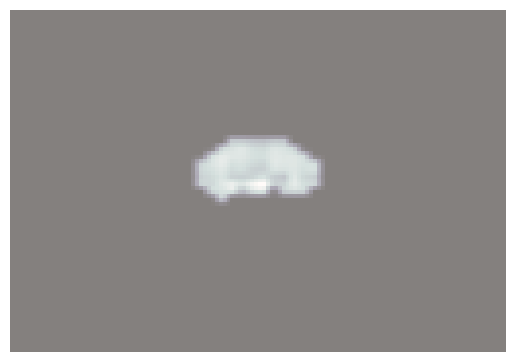

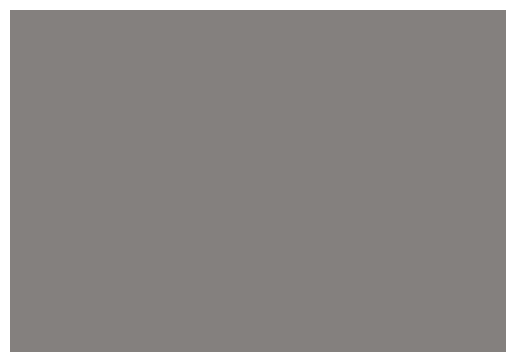

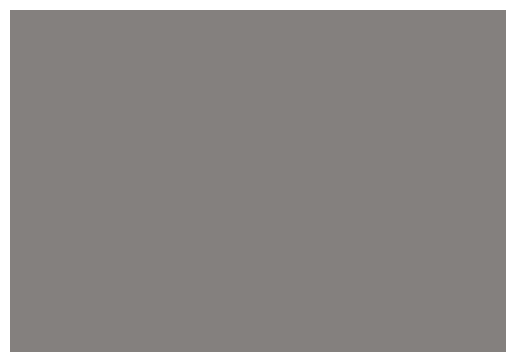

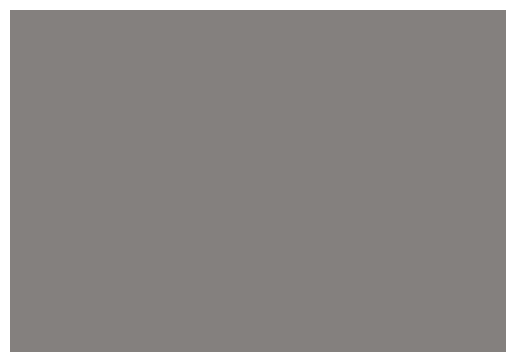

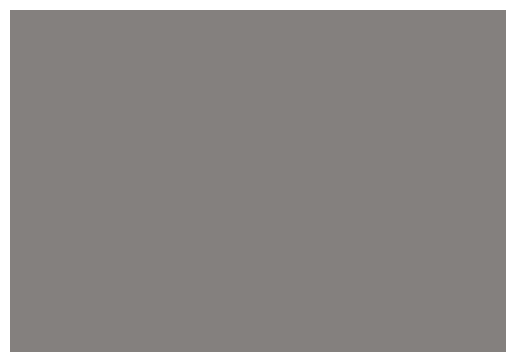

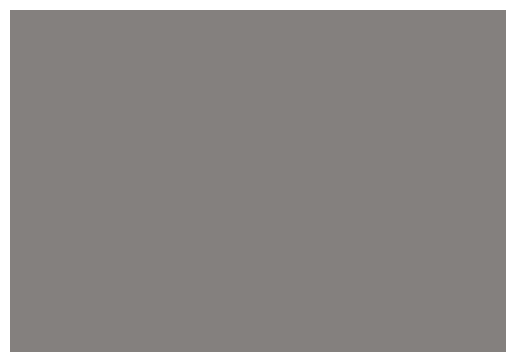

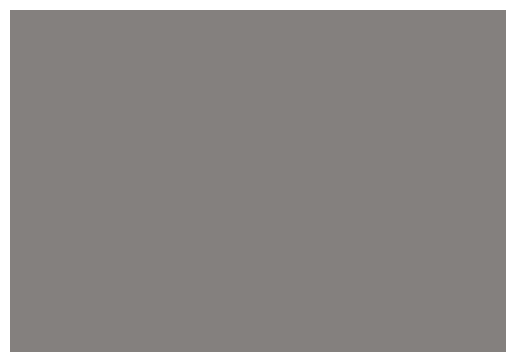

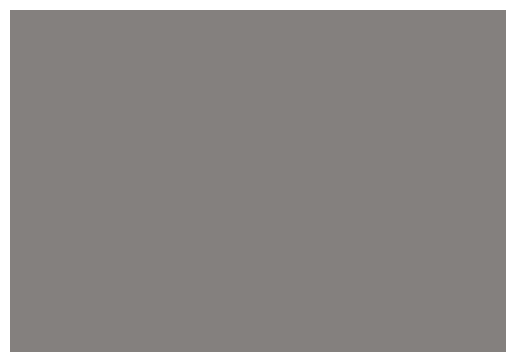

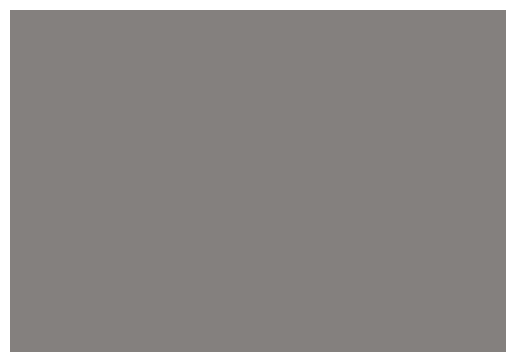

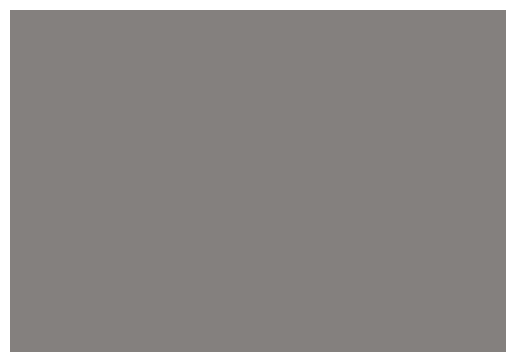

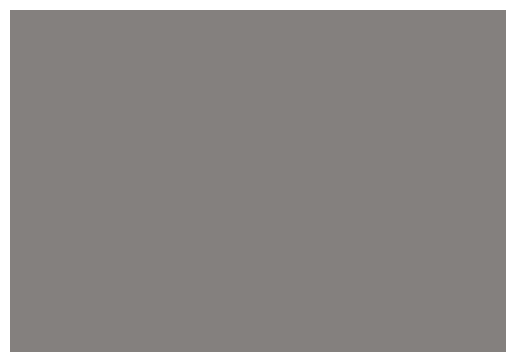

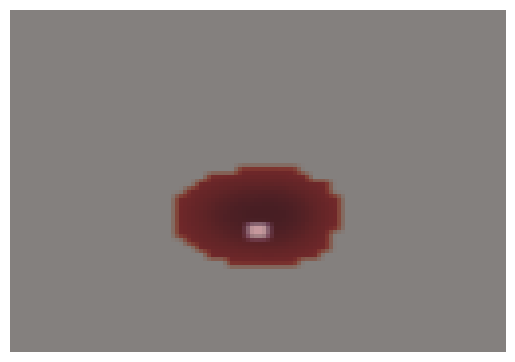

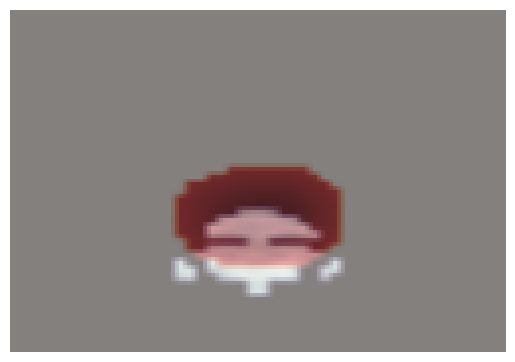

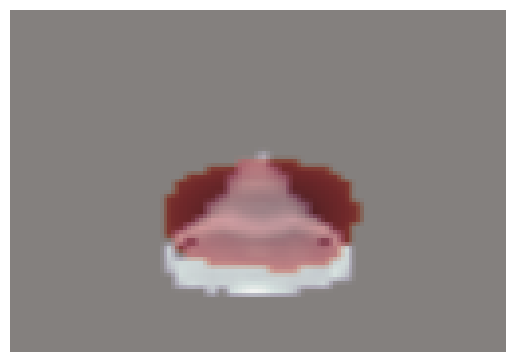

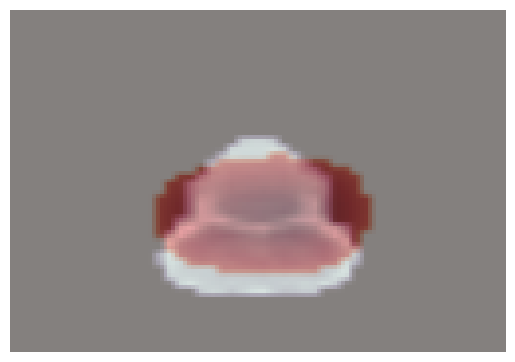

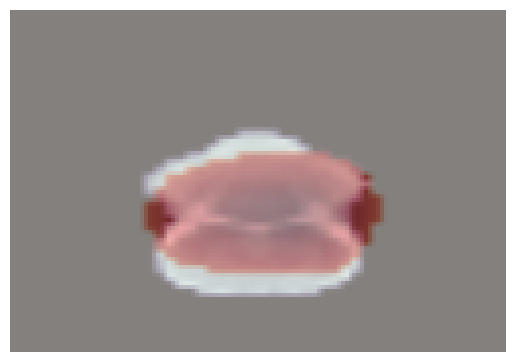

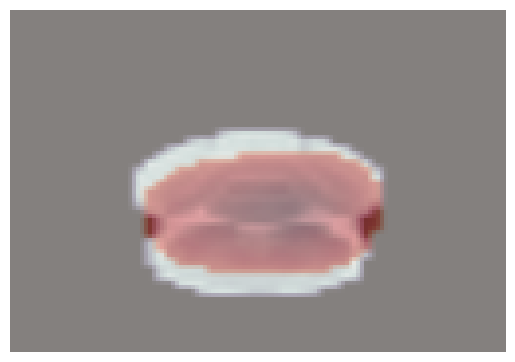

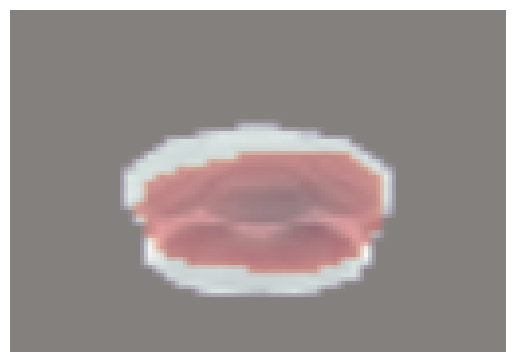

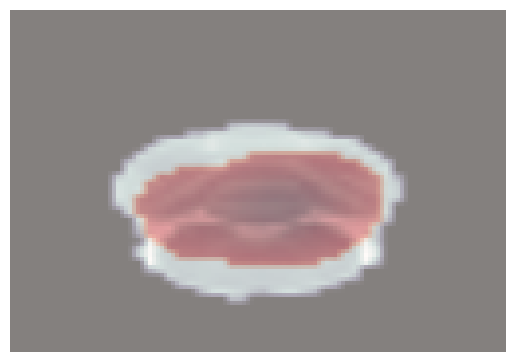

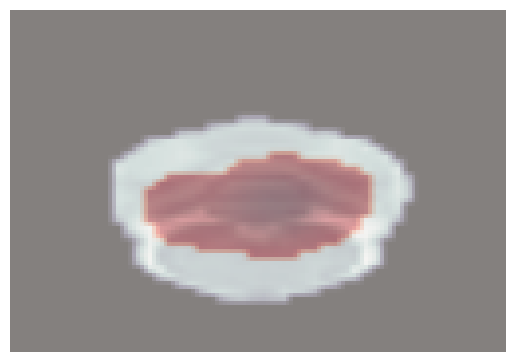

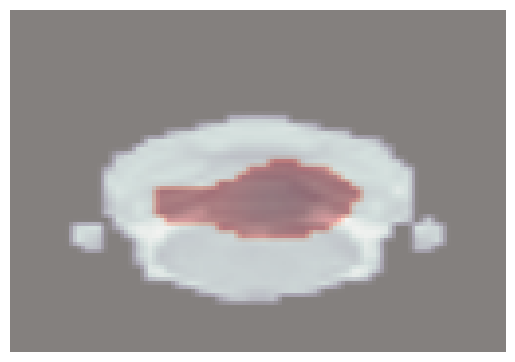

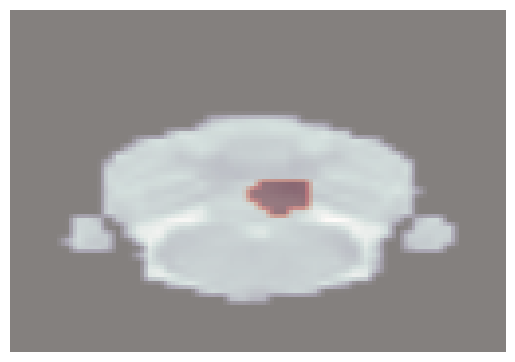

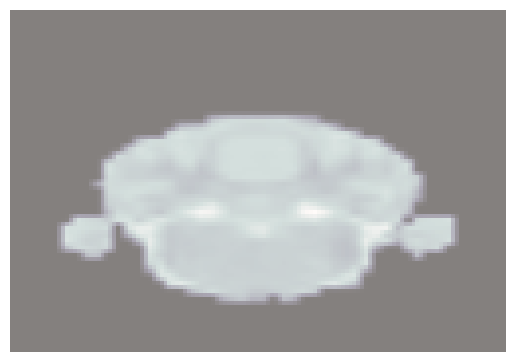

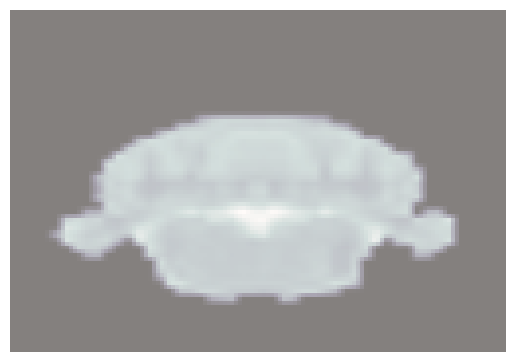

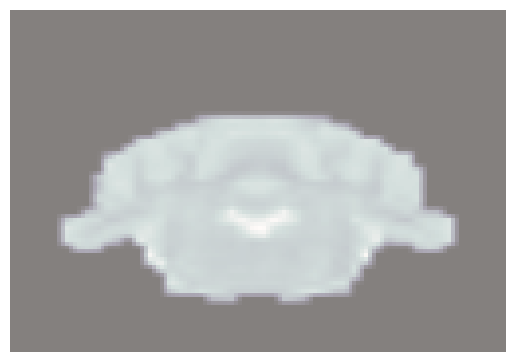

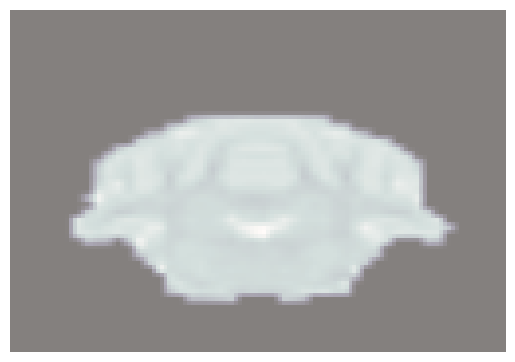

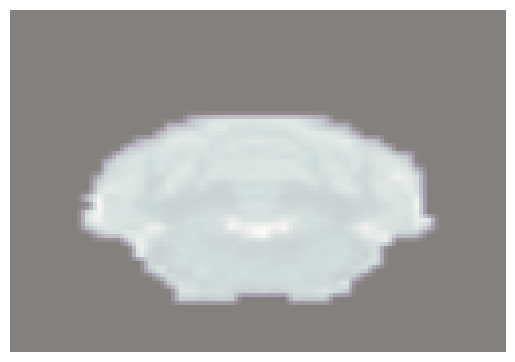

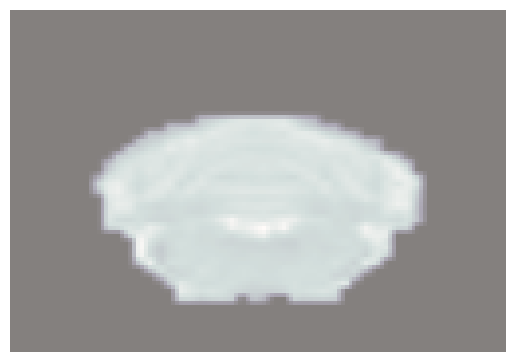

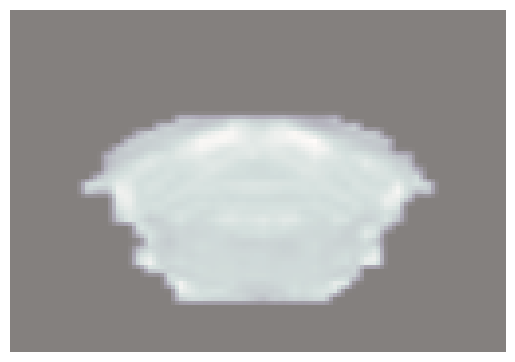

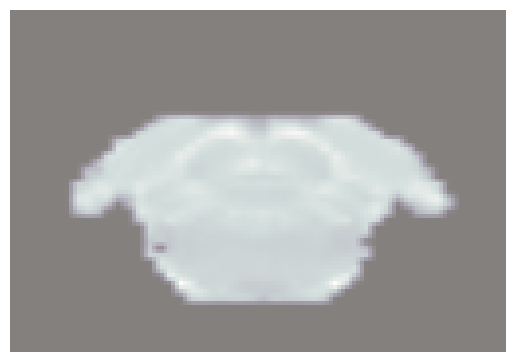

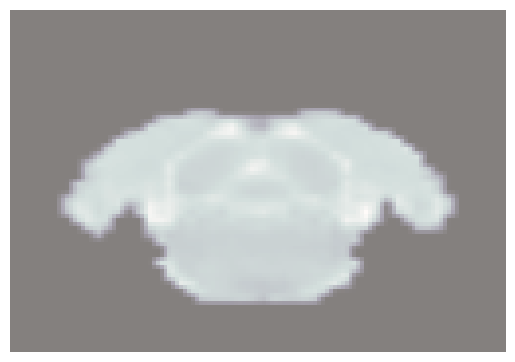

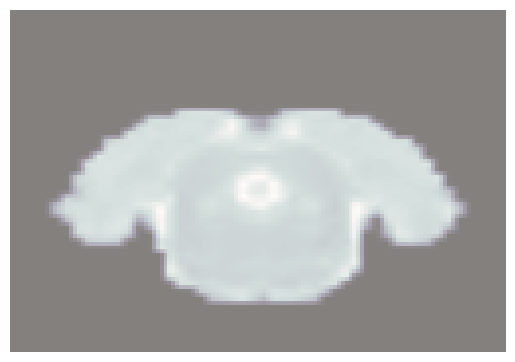

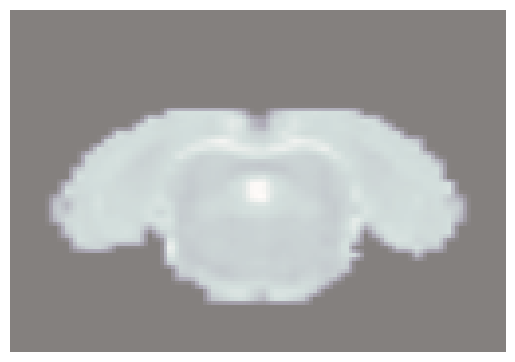

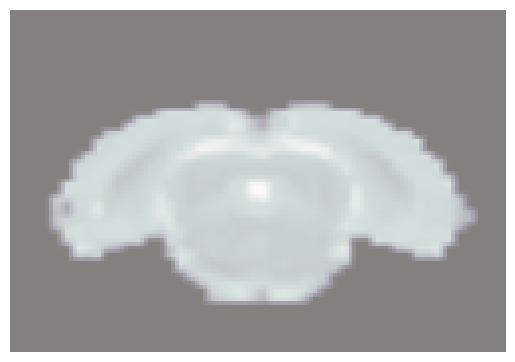

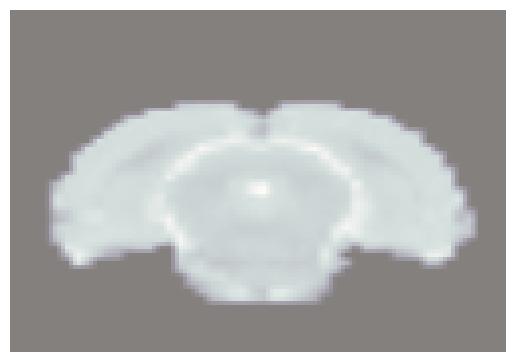

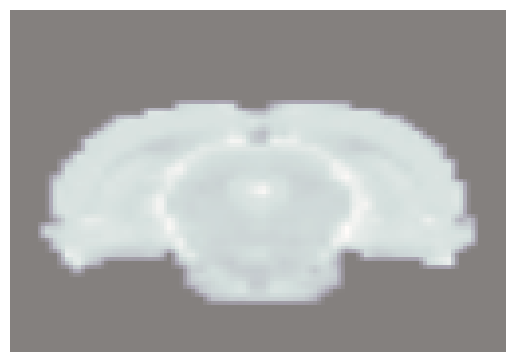

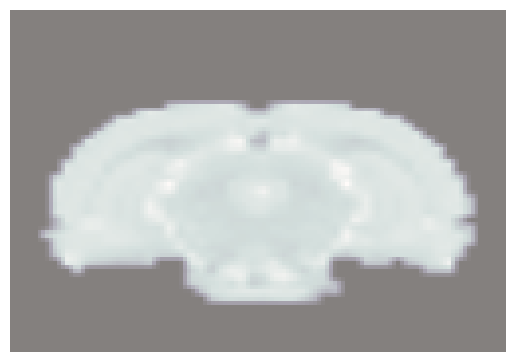

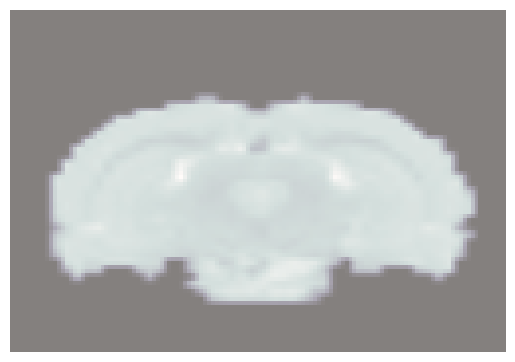

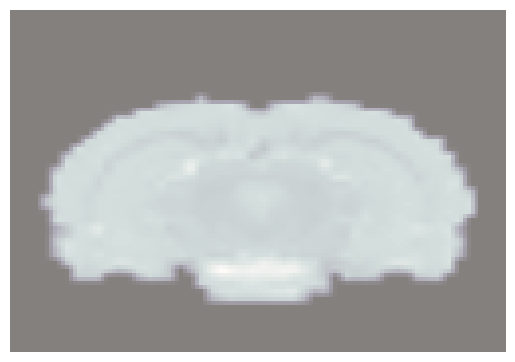

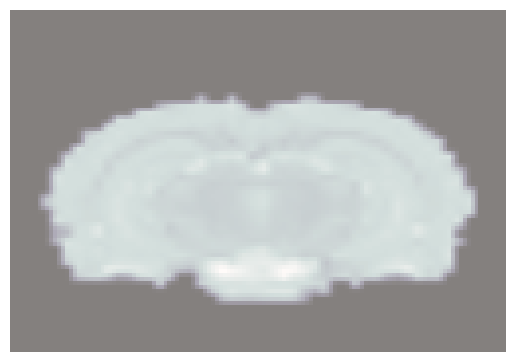

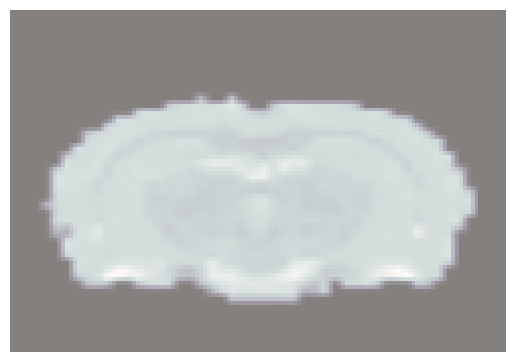

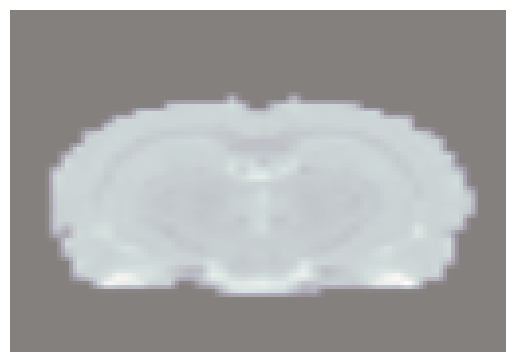

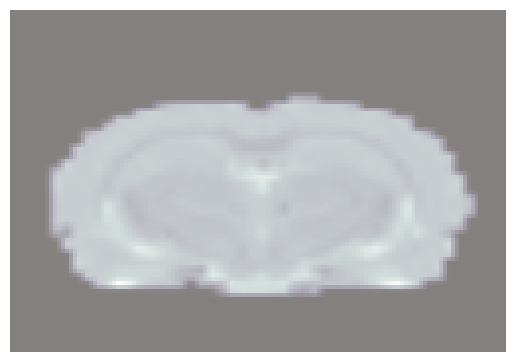

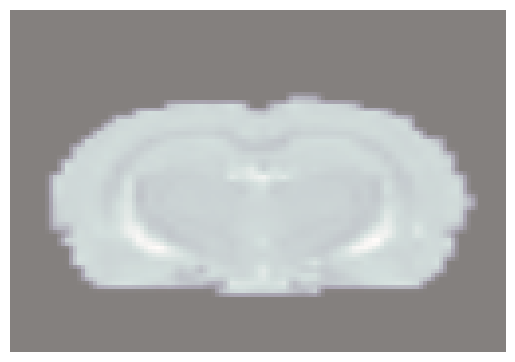

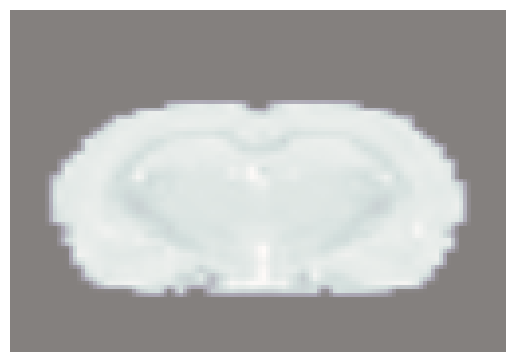

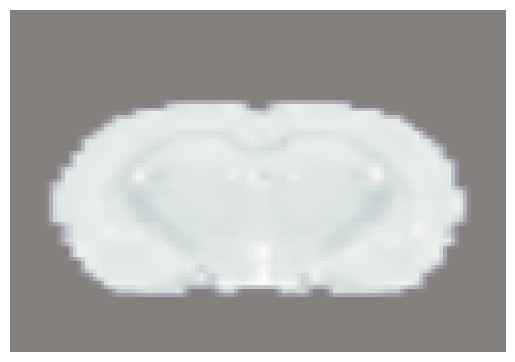

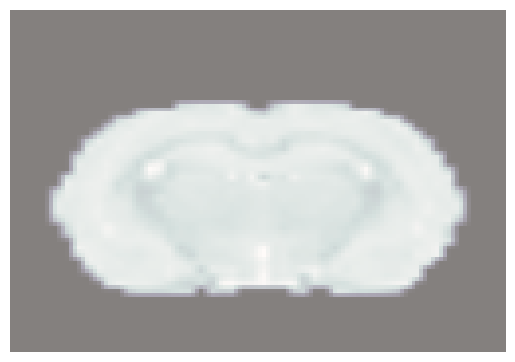

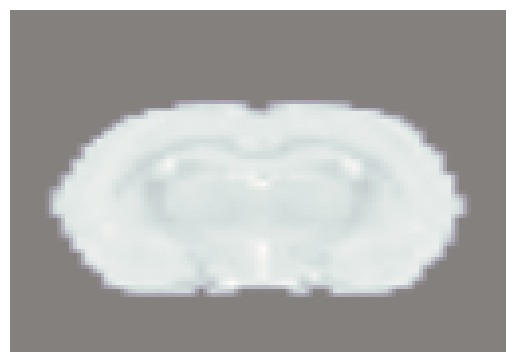

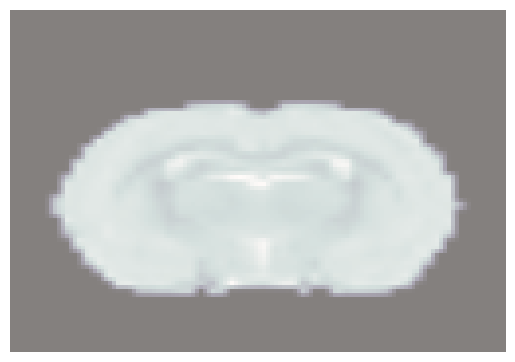

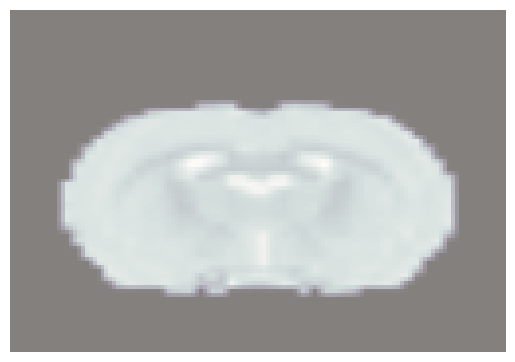

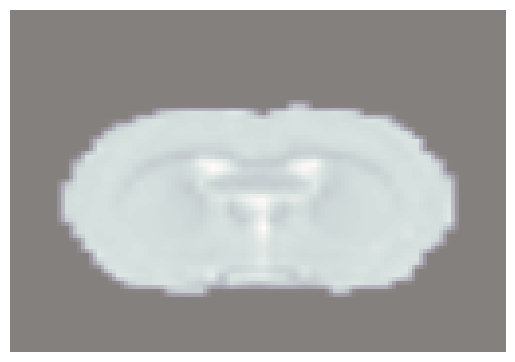

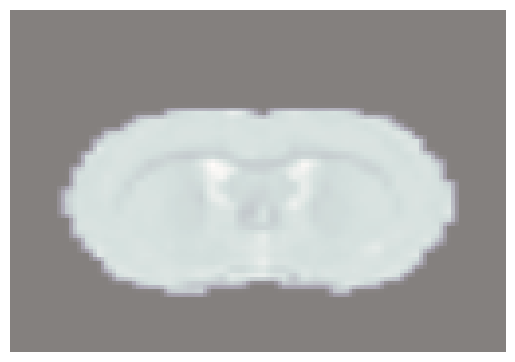

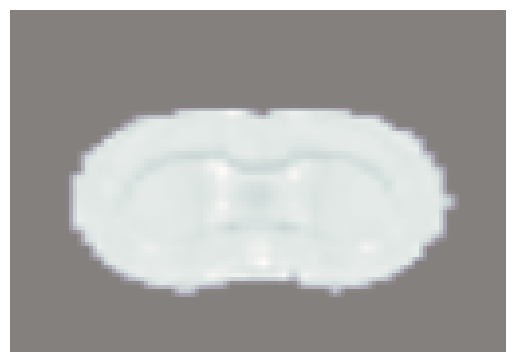

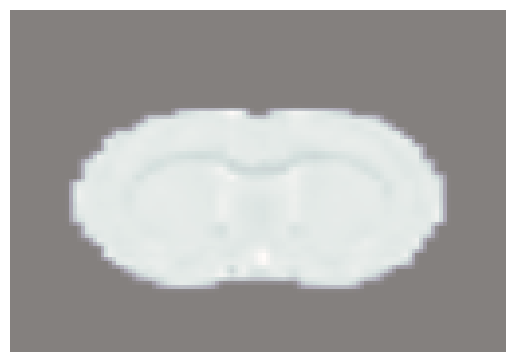

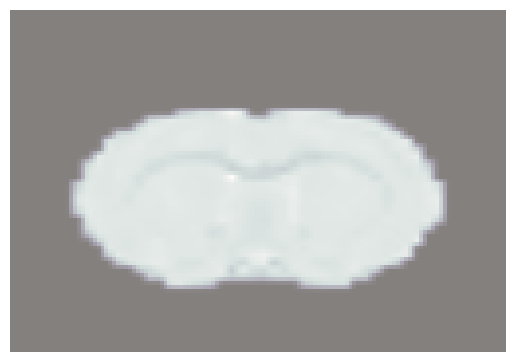

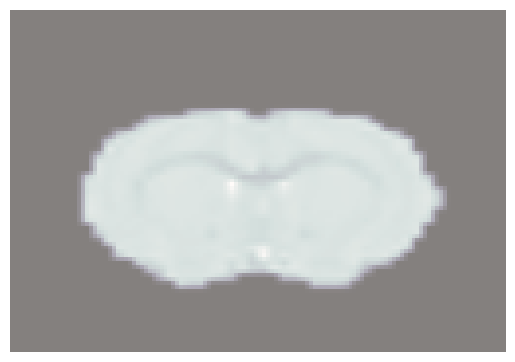

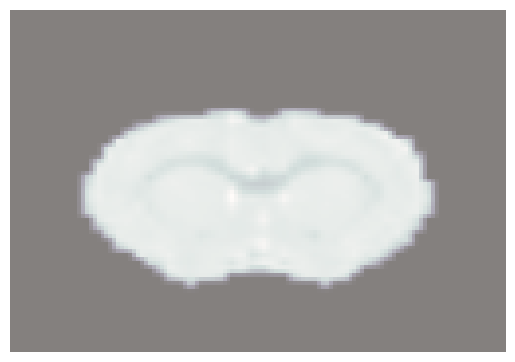

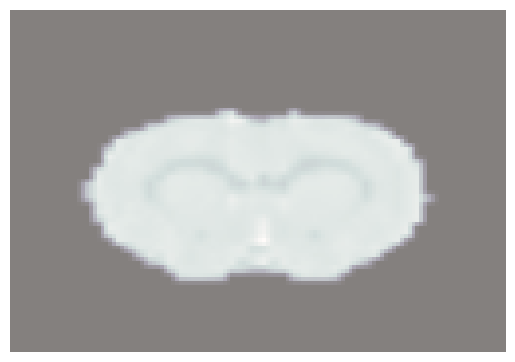

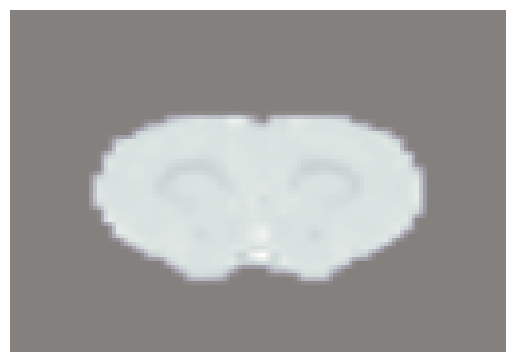

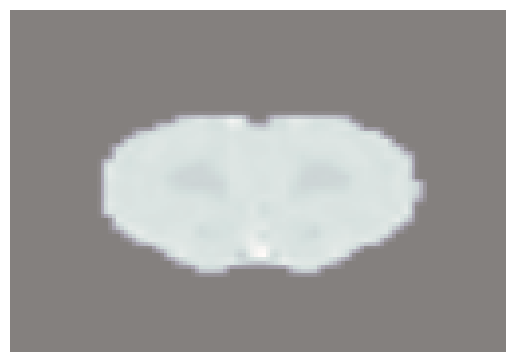

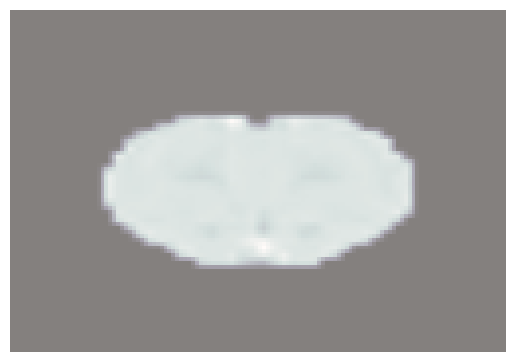

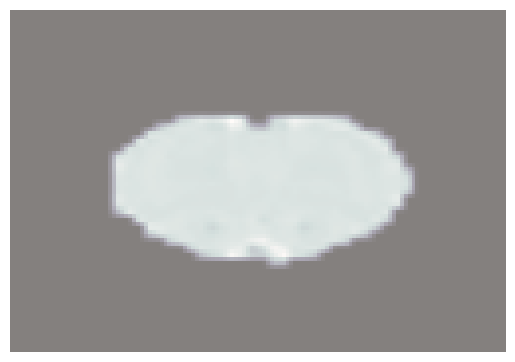

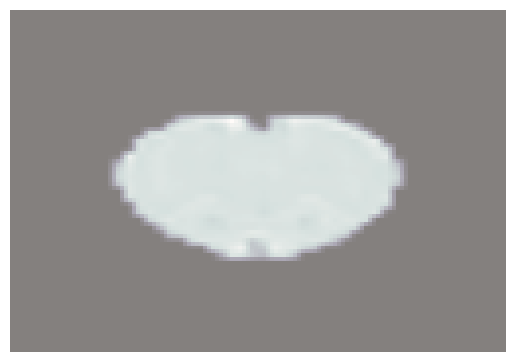

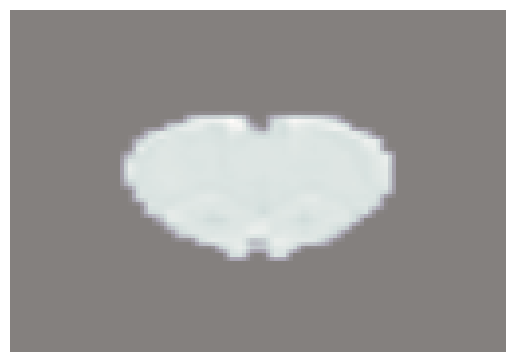

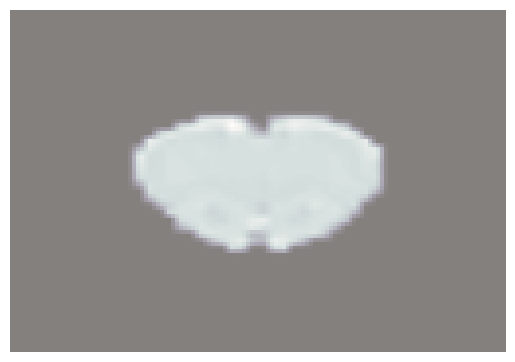

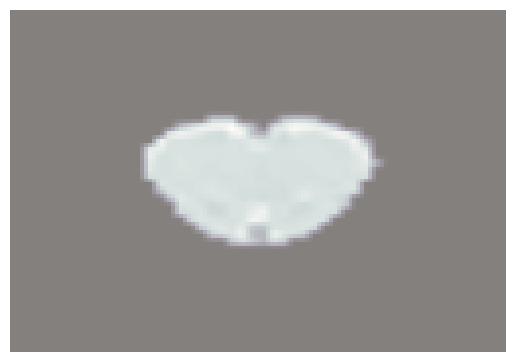

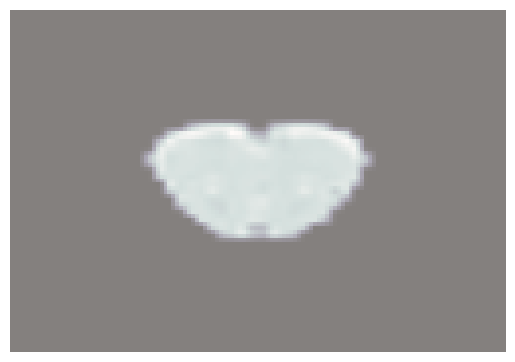

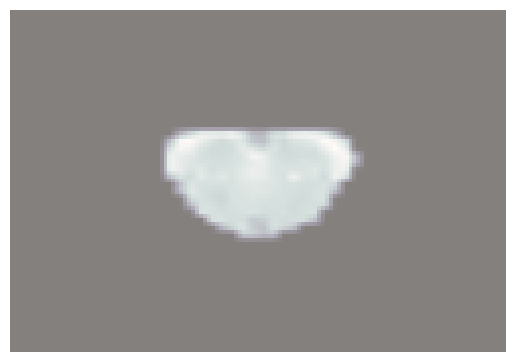

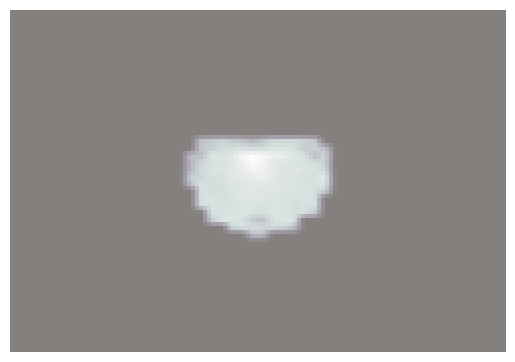

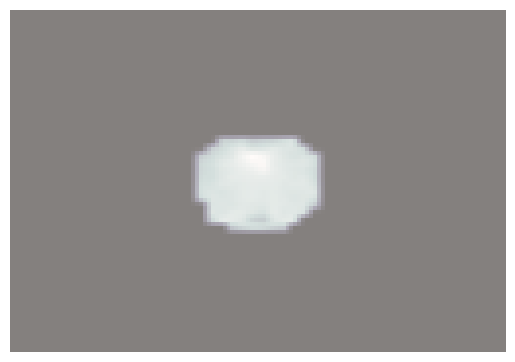

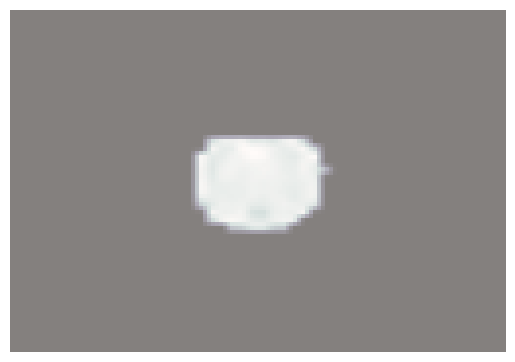

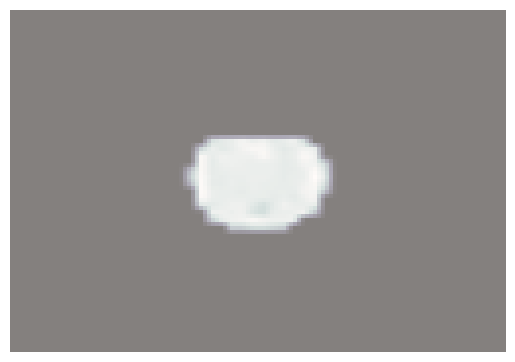

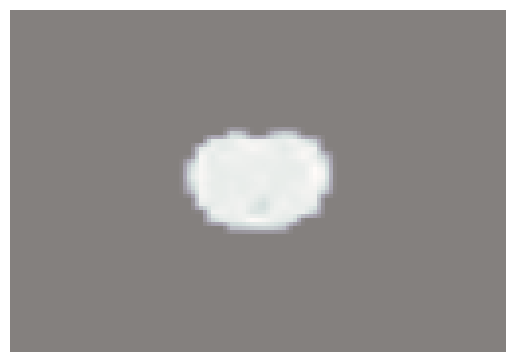

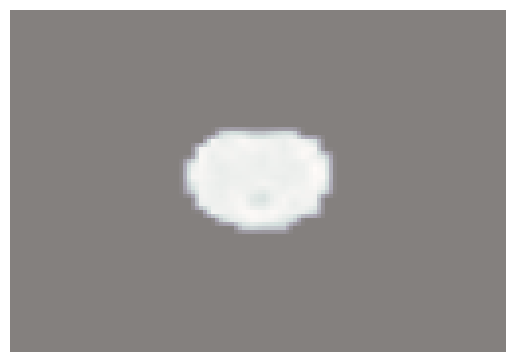

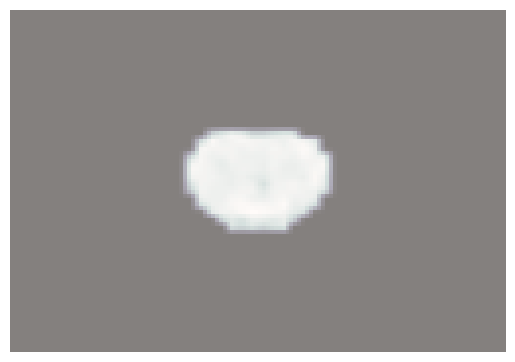

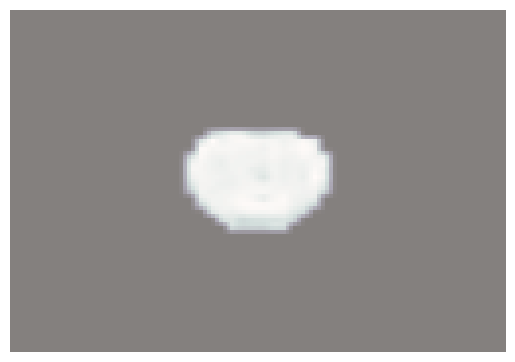

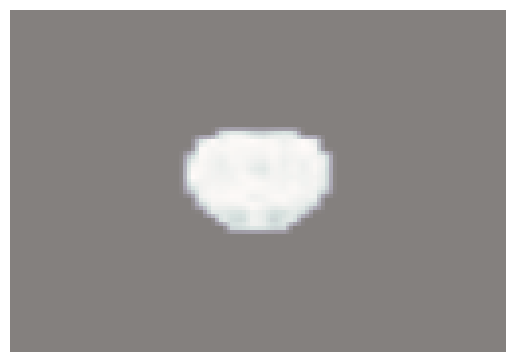

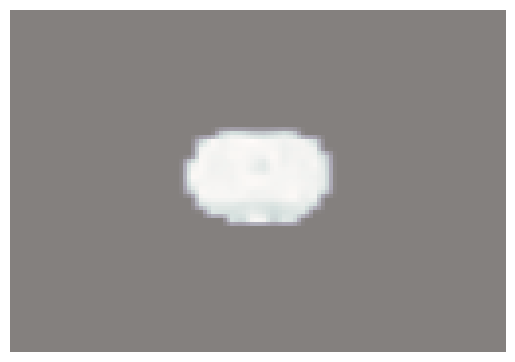

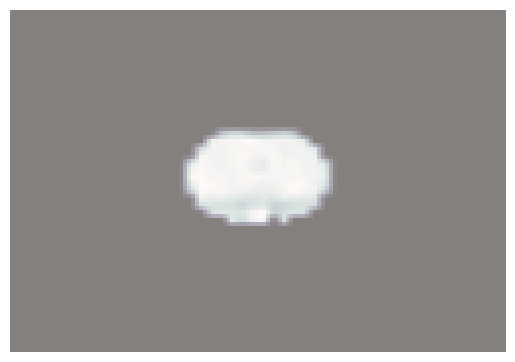

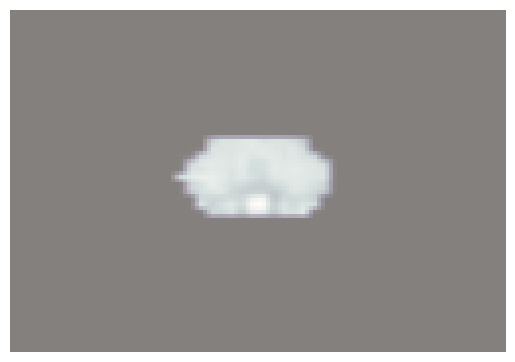

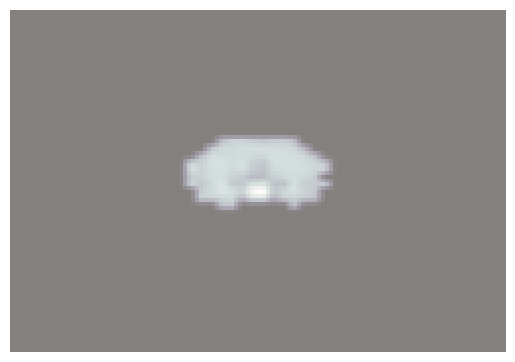

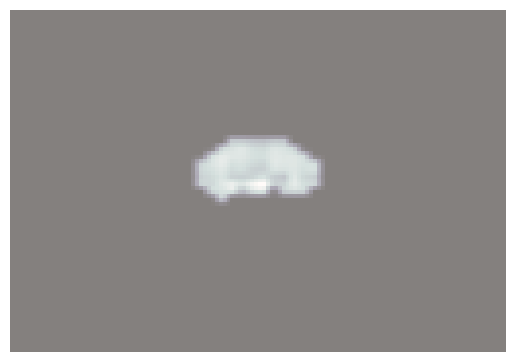

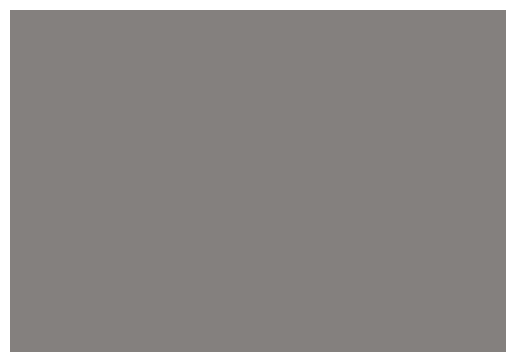

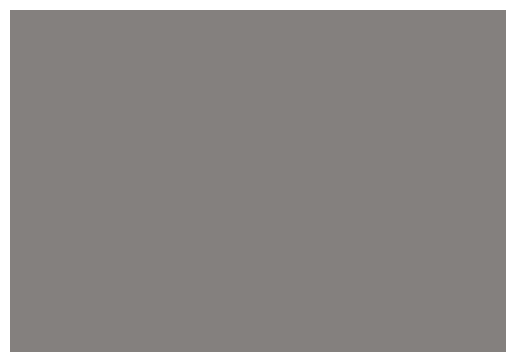

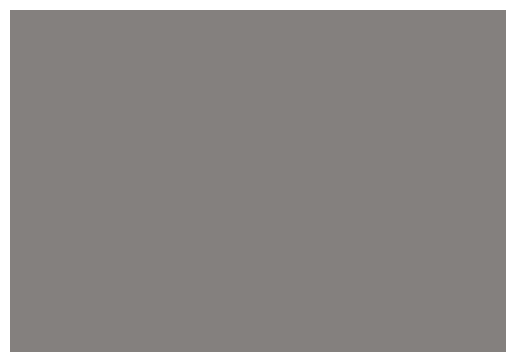

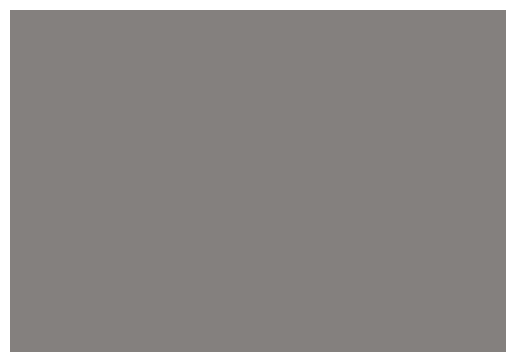

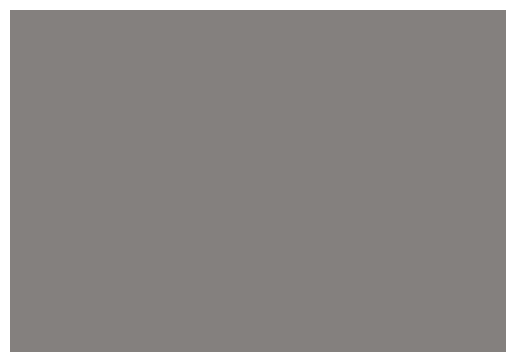

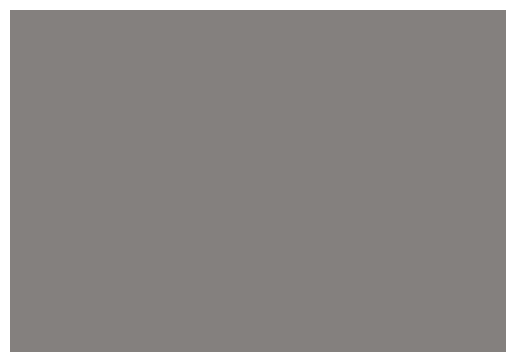

CM CNN


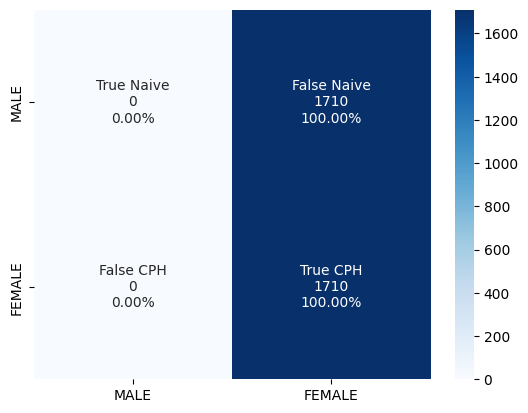

wandb: WARNING `format` argument was not provided, defaulting to `gif`. This parameter will be required in v0.20.0, please specify the format explicitly.
wandb: WARNING `format` argument was not provided, defaulting to `gif`. This parameter will be required in v0.20.0, please specify the format explicitly.
wandb: WARNING `format` argument was not provided, defaulting to `gif`. This parameter will be required in v0.20.0, please specify the format explicitly.
wandb: WARNING `format` argument was not provided, defaulting to `gif`. This parameter will be required in v0.20.0, please specify the format explicitly.


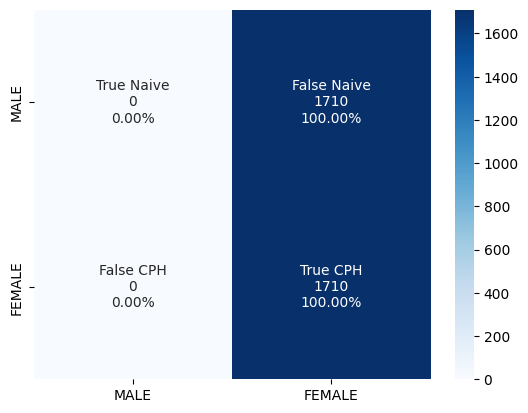

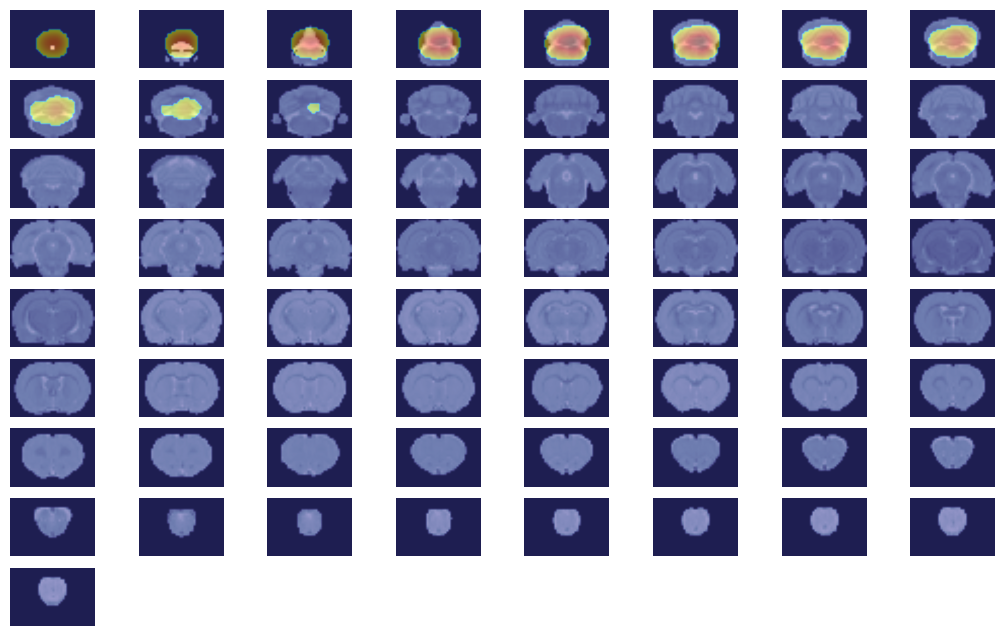

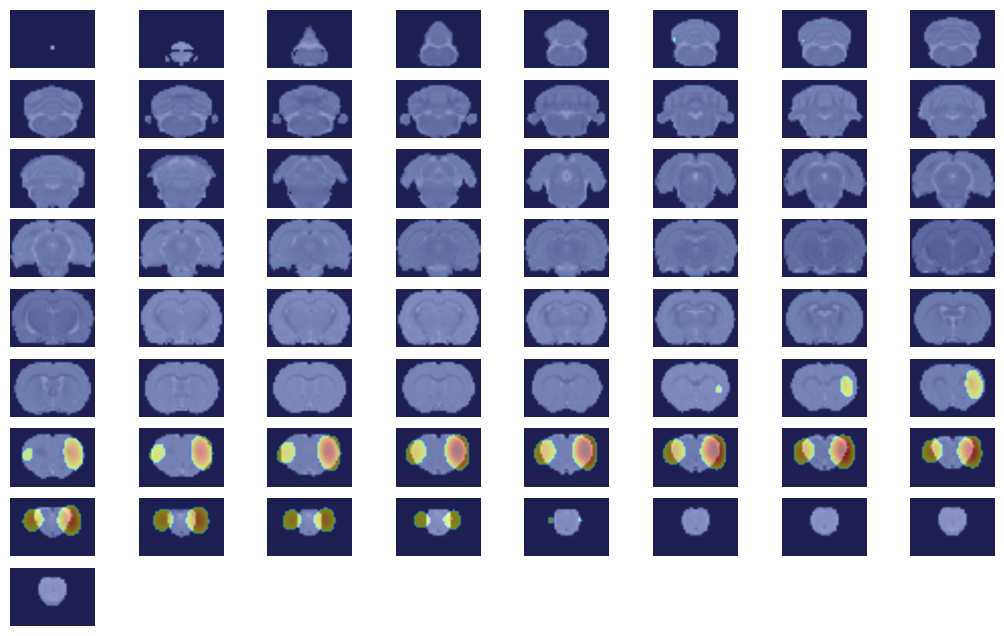

Run # 2


Accuracy,▁▁▁▅██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▄▃▃▂▁▁
test_acc,▁
val_Accuracy,████▁█████
val_loss,█▇▆▅▄▃▃▂▁▁
Accuracy,0.99803
epoch,9
loss,25.92857
test_acc,0.5
time_running,5:32:29.775571


sub train:
['F:/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id095.session01_split_name_sub-095_ses-01_desc-o_T2w/_run_None/sub-095_ses-01_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'F:/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id093.session01_split_name_sub-093_ses-01_desc-o_T2w/_run_None/sub-093_ses-01_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'F:/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id095.session01_split_name_sub-095_ses-01_desc-o_T2w/_run_None/sub-095_ses-01_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'F:/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id095.session01_split_name_sub-095_ses-01_desc-o_T2w/_run_None/sub-095_ses-01_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'F:/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id095.session03_split_name_sub-095_ses-03_des

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\rich-shape-4\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\rich-shape-4\assets


152/152 [==============================] - 2142s 14s/step - loss: 64.3225 - Accuracy: 0.7467 - val_loss: 62.2363 - val_Accuracy: 0.5000 - combine_metric: 0.0080
Epoch 2/10
152/152 [==============================] - 2180s 14s/step - loss: 59.4886 - Accuracy: 0.9322 - val_loss: 57.6572 - val_Accuracy: 0.0649 - combine_metric: 0.0011
Epoch 3/10
152/152 [==============================] - ETA: 0s - loss: 54.8413 - Accuracy: 0.9686 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\rich-shape-4\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\rich-shape-4\assets


152/152 [==============================] - 2298s 15s/step - loss: 54.8413 - Accuracy: 0.9686 - val_loss: 53.0660 - val_Accuracy: 0.5000 - combine_metric: 0.0094
Epoch 4/10
152/152 [==============================] - ETA: 0s - loss: 50.3946 - Accuracy: 0.9851 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\rich-shape-4\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\rich-shape-4\assets


152/152 [==============================] - 2393s 16s/step - loss: 50.3946 - Accuracy: 0.9851 - val_loss: 48.7628 - val_Accuracy: 0.5000 - combine_metric: 0.0103
Epoch 5/10
152/152 [==============================] - ETA: 0s - loss: 46.1905 - Accuracy: 0.9956 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\rich-shape-4\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\rich-shape-4\assets


152/152 [==============================] - 2168s 14s/step - loss: 46.1905 - Accuracy: 0.9956 - val_loss: 44.7039 - val_Accuracy: 0.5000 - combine_metric: 0.0112
Epoch 6/10
152/152 [==============================] - ETA: 0s - loss: 42.2521 - Accuracy: 0.9961 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\rich-shape-4\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\rich-shape-4\assets


152/152 [==============================] - 2106s 14s/step - loss: 42.2521 - Accuracy: 0.9961 - val_loss: 40.9213 - val_Accuracy: 0.5000 - combine_metric: 0.0122
Epoch 7/10
152/152 [==============================] - ETA: 0s - loss: 38.5975 - Accuracy: 0.9961 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\rich-shape-4\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\rich-shape-4\assets


152/152 [==============================] - 2439s 16s/step - loss: 38.5975 - Accuracy: 0.9961 - val_loss: 37.3508 - val_Accuracy: 0.5000 - combine_metric: 0.0134
Epoch 8/10
152/152 [==============================] - ETA: 0s - loss: 35.2288 - Accuracy: 0.9961 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\rich-shape-4\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\rich-shape-4\assets


152/152 [==============================] - 2100s 14s/step - loss: 35.2288 - Accuracy: 0.9961 - val_loss: 34.1247 - val_Accuracy: 0.5000 - combine_metric: 0.0147
Epoch 9/10
 44/152 [=======>......................] - ETA: 28:02 - loss: 33.1956 - Accuracy: 0.9977

In [ ]:
# test va adentro 
# 80% train y val y 20% test

'''sub_trainval, sub_test, y_trainval, y_test = train_test_split(
    subjects, labels, test_size=0.2, random_state=42, stratify=labels
)'''

n_bootstraps= 1 #2
for boot in range(n_bootstraps): 
    print(f"\n=== Bootstrapping Run {boot+1}/{n_bootstraps} ===")

    # Resample subjects + labels con reemplazo
    boot_subjects, boot_labels = resample(
     subjects, labels, replace=True, random_state=42+boot
    )

    sub_trainval, sub_test, y_trainval, y_test = train_test_split(
    boot_subjects, boot_labels, test_size=0.2, random_state=42, stratify=labels
)

    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

    scores, histories = list(), list()
    run = 1
    for train_ix, val_ix in kfold.split(sub_trainval, y_trainval):
        print("Run #",run)

        sub_train, sub_val = boot_subjects[train_ix], boot_subjects[val_ix]
        y_train, y_val     = boot_labels[train_ix], boot_labels[val_ix]
        
        
        # Set default values
        config_defaults = {
            "batch": 4,
        }
        
        # Initialize wandb with a sample project name
        wandb.init(project="MALE_Naive_vs_CPH(BLvsW7)", notes="No pooling. New data augmentation. Z-scoring per batch. Batch = 4. 10 epoch. Just z-scoring and applying RandomFlip. All layers gradcam. lr = 1e-5",
                    config=config_defaults)

        # Specify the other hyperparameters to the configuration.
        wandb.config.epochs = 10 #10
        wandb.config.sub_batch = 30
        wandb.config.sub_batch_ts = 30
        wandb.config.subjects = subjects
        wandb.config.architecture_name = "VGG16_3D"
        wandb.config.dataset_name = "NAIVE vs CPH(CPH[Bl-W1])"
        wandb.config.CNN_blocks = 5
        wandb.config.sessions = sessions
        wandb.config.vols_per_session_tr = 570
        wandb.config.vols_per_session_ts = 570
        wandb.config.initial_learning_rate = 1e-5
        #wandb.config.lr_decay_rate = 0.95
        wandb.config.optimizer = "Adam"
        
        
        #
        val_size = max(2, int(round(0.1 * len(train_ix))))
    
        sub_train, sub_val, y_train, y_val = train_test_split(
            sub_trainval[train_ix], y_trainval[train_ix],
            test_size=val_size,  # test_size se refiere a la validacion
            random_state=42, stratify=y_trainval[train_ix]
        )

        sub_test, y_test = sub_test, y_test
        #
        
        CPHclassTrain = FILES_and_LABELS(sub_train, sessions, MRI_type, functional_type)
        CPHclassTest = FILES_and_LABELS(sub_test, sessions, MRI_type, functional_type)
        CPHclassval = FILES_and_LABELS(sub_val, sessions, MRI_type, functional_type)
            
        X_train = CPHclassTrain.get_mask_and_bold()
        X_test = CPHclassTest.get_mask_and_bold()
        X_val = CPHclassval.get_mask_and_bold()

        wandb.config.batch = 4

        print("sub train:")
        print(np.array(X_train)[:,0])
        print("sub test:")
        print(np.array(X_test)[:,0])
        print("sub val:")
        print(np.array(X_val)[:,0])

        print("# sesiones Train",len(X_train))
        print("# sesiones Test",len(X_test))
        print("# sesiones Val",len(X_val))
        
        traingen = CustomDataGen(X_train, batch_size=wandb.config.batch, subbatch_size=wandb.config.sub_batch,
                                    format = "just_brain", vols = wandb.config.vols_per_session_tr,
                                    num_class = 2, classes = "CPHvsNAIVEmale", augmentation = True)
        traingen.on_epoch_end()
        #Es necesario que la division entre X_test y batch_size tenga un modulo igual a 0. 
        #De otra manera el ultimo batch no lo utiliza al utilizar .predict
        testgen  = CustomDataGen(X_test, batch_size=1,subbatch_size=wandb.config.sub_batch_ts,
                                    format = "just_brain", vols= wandb.config.vols_per_session_ts,
                                    num_class = 2, classes = "CPHvsNAIVEmale",shuffle=False)
        valgen  = CustomDataGen(X_val, batch_size=len(X_val),subbatch_size=30, format = "just_brain",vols=570, num_class = 2, classes = "CPHvsNAIVEmale")
        
        #getting model 3D CNN
        #callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)
        print("Starting VGG 16 3D-----------------------------------------------------")
        tf.keras.backend.clear_session()
        gc.collect()
        CNN = VGG16_3D(3)
        set_pretrained_weigths(CNN)

        """
        lr_schedule = ExponentialDecay(wandb.config.initial_learning_rate,
                                        decay_steps=int((wandb.config.vols_per_session_tr/wandb.config.sub_batch)*len(X_train)),
                                        decay_rate=wandb.config.lr_decay_rate, staircase=True)
        """
        CNN.compile(loss=tf.nn.softmax_cross_entropy_with_logits, optimizer=tf.keras.optimizers.Adam(learning_rate=wandb.config.initial_learning_rate),
                        metrics=["Accuracy"])

        checkpoint_filepath = os.getcwd()+"/"+wandb.run.name
        #'/tmp/ckpt/MalevsFemale(CPH)_3D-VGG16_flips/'+wandb.run.name

        acc_loss_rate = CombineCallback()
        
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='combine_metric', mode='max',
                                                                save_best_only=True)
        
        if os.path.exists(checkpoint_filepath):
            print("Loading previous weights from:", checkpoint_filepath)
            CNN.load_weights(checkpoint_filepath)
        else:
            print("No previous checkpoint found, starting fresh.")

        
        start_time = datetime.now()
        
        print("Training")
        
        history = CNN.fit(traingen, epochs=wandb.config.epochs, validation_data = valgen, shuffle=True,
                            callbacks=[WandbCallback(monitor='combine_metric',mode="max",save_model=(False)),acc_loss_rate,model_checkpoint_callback])
        
        end_time = datetime.now()
        print('Duration (CNN): {}'.format(end_time - start_time))

        print("Evaluating best epoch")
        CNN.load_weights(checkpoint_filepath)
        CNN.compile(loss=tf.nn.softmax_cross_entropy_with_logits, optimizer=tf.keras.optimizers.Adam(learning_rate=wandb.config.initial_learning_rate),
                        metrics=["Accuracy"])
        _,acc = CNN.evaluate(testgen, verbose=1)

        y_test=[]
        x_vols = []
        for i in range(int(len(X_test)*(wandb.config.vols_per_session_ts/wandb.config.sub_batch_ts))):
            x,y = testgen[i]
            y_test.extend(y)
            x_vols.extend(x)
        y_test = np.argmax(y_test, axis=1)

        
        print("predicts CNN")
        preds = tf.cast(tf.argmax(CNN.predict(testgen), axis=1), tf.int32)

        #Wrong predicted subjects
        wrong_labeled_subj = mislabeled_subj(y_test, preds, X_test, wandb.config.vols_per_session_ts)

        print("mislabeled subjects:\n",wrong_labeled_subj)
        
        scores.append(acc)
        histories.append(history)

        #GradCam
        #Naive
        if not os.path.exists(os.getcwd()+"/"+wandb.run.name+"/Naive"): 
            # if the demo_folder directory is not present  
            # then create it. 
            os.makedirs(os.getcwd()+"/"+wandb.run.name+"/Naive")
        #CPH
        if not os.path.exists(os.getcwd()+"/"+wandb.run.name+"/CPH"): 
            # if the demo_folder directory is not present  
            # then create it. 
            os.makedirs(os.getcwd()+"/"+wandb.run.name+"/CPH")

        all_layers = [layer.name for layer in reversed(CNN.layers) if len(layer.output_shape) == 5 and (layer.__class__.__name__ == 'ReLU' or isinstance(layer, tf.keras.layers.Conv3D))]
        
        index_naive = index_for_gradcam(0,y_test,preds)
        index_cph = index_for_gradcam(1,y_test,preds)


        if index_naive is None:
            index_naive = 0

            print("No se encontró ningún sujeto Naive correctamente clasificado")
            print("index_naive se pone en 0 SOLO para poder correr el GradCAM")


        if index_cph is None:
            print("No se encontró ningún sujeto CPH correctamente clasificado")
            print("index_cph se pone en 0 SOLO para poder correr el GradCAM")
            index_cph = 0

        
        #if index_naive is not None and index_cph is not None:

        rabies_crop= rabies_vol[3:45, 4:69, 7:36] #original 48,81,48 #cropped 42,65,29

        # GradCAM por clase
        heatmap_naive = make_gradcam_heatmap(np.expand_dims(x_vols[index_naive], axis=0), CNN, all_layers[0])
        heatmap_cph   = make_gradcam_heatmap(np.expand_dims(x_vols[index_cph],   axis=0), CNN, all_layers[0])
        

        resized_heatmap_naive = get_resized_heatmap(heatmap_naive, rabies_crop.shape[0:3])
        resized_heatmap_cph   = get_resized_heatmap(heatmap_cph, rabies_crop.shape[0:3])

   
        resized_heatmap_naive= (filter_heatmap(resized_heatmap_naive, threshold=0.6))
        resized_heatmap_cph= (filter_heatmap(resized_heatmap_cph, threshold=0.6))
      
        # Animaciones coronal
        gradcam_naive = create_animation(rabies_crop, 'Naive', heatmap=resized_heatmap_naive)
        gradcam_cph   = create_animation(rabies_crop,   'CPH',   heatmap=resized_heatmap_cph)

        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

        name_ani_naive = os.getcwd() + "/" + wandb.run.name + "/Naive/GradCam_Naive(BlVsW1-CPH).mp4"
        gradcam_naive.save(name_ani_naive, writer=writer)

        name_ani_CPH = os.getcwd() + "/" + wandb.run.name + "/CPH/GradCam_CPH(BlVsW1-CPH).mp4"
        gradcam_cph.save(name_ani_CPH, writer=writer)

        # GradCAM promedio de todas las capas convolucionales
        print("GradCam All ConvLayers")
        all_layers_gradcam_naive = fuse_layers(all_layers, CNN, [x_vols[index_naive]], 0, emphasize=False)
        all_layers_gradcam_cph   = fuse_layers(all_layers, CNN,[x_vols[index_cph]], 0,   emphasize=False)

        all_layers_animation_naive = create_animation(rabies_crop, 'all_layers_gradcam_Naive', heatmap=all_layers_gradcam_naive)
        all_layers_animation_cph   = create_animation(rabies_crop,   'all_layers_gradcam_CPH',   heatmap=all_layers_gradcam_cph)

        name_all_naive = os.getcwd() + "/" + wandb.run.name + "/Naive/all_layers_gradcam_Naive.mp4"
        all_layers_animation_naive.save(name_all_naive, writer=writer)

        name_all_cph = os.getcwd() + "/" + wandb.run.name + "/CPH/all_layers_gradcam_CPH.mp4"
        all_layers_animation_cph.save(name_all_cph, writer=writer)


        print("Máximo valor del heatmap CPH:", np.max(resized_heatmap_cph))
        print("Máximo valor del heatmap Naive:", np.max(resized_heatmap_naive))

        # Guardar PNGs frame por frame

        full_grad_cph=np.zeros_like(rabies_vol)
        full_grad_naive=np.zeros_like(rabies_vol)
        full_grad_cph[3:45, 4:69, 7:36] = resized_heatmap_cph
        full_grad_naive[3:45, 4:69, 7:36] = resized_heatmap_naive   

        #rabies_vol= np.mean(rabies_ref, axis=3) #48,81,48
        for i in range(rabies_vol.shape[1]):
            plt.imshow(cv2.resize(np.rot90(rabies_vol[:,i,:]), dsize=(126,87)), alpha=0.8, cmap='bone')
            plt.imshow(cv2.resize(np.rot90(full_grad_cph[:,i,:]), dsize=(126,87)), alpha=0.4, cmap='Reds')
            plt.axis('off')
            plt.savefig(os.getcwd()+"/"+wandb.run.name+"/CPH/"+str(i)+".png")
            plt.show()

        for i in range(rabies_vol.shape[1]):
            plt.imshow(cv2.resize(np.rot90(rabies_vol[:,i,:]), dsize=(126,87)), alpha=0.8, cmap='bone')
            plt.imshow(cv2.resize(np.rot90(full_grad_naive[:,i,:]), dsize=(126,87)), alpha=0.4, cmap='Reds')
            plt.axis('off')
            plt.savefig(os.getcwd()+"/"+wandb.run.name+"/Naive/"+str(i)+".png")
            plt.show()

        # Guardar arrays GradCAM
        np.save(os.getcwd()+"/"+wandb.run.name+"/CPH/Array_GradCam-CPH", resized_heatmap_cph)
        np.save(os.getcwd()+"/"+wandb.run.name+"/Naive/Array_GradCam-Naive", resized_heatmap_naive)

        print("CM CNN")
        cm = confusionmatrix(y_test, preds)

        # Log completo en Weights & Biases
        wandb.log({
            'test_acc': float(acc),
            'time_running': '{}'.format(end_time - start_time),
            'confution_matrix': wandb.Image(cm),
            'mislabeled_subj': wrong_labeled_subj,
            'GradCam_Naive-coronal': wandb.Video(name_ani_naive),
            'GradCam-CPH-coronal': wandb.Video(name_ani_CPH),
            'GradCam_Naive_all-layers': wandb.Video(name_all_naive),
            'GradCam-CPH_all-layers': wandb.Video(name_all_cph),
            'GradCam-per_frames-Naive': wandb.Image(grad_cam_per_frames(rabies_crop, resized_heatmap_naive, threshold=0.3)),
            'GradCam-per_frames-CPH': wandb.Image(grad_cam_per_frames(rabies_crop, resized_heatmap_cph, threshold=0.3))
        })


        run = run + 1
            
    print("histories and scores from VGG 16 M2D") 
    summarize_diagnostics(histories)
    summarize_performance(scores)

    wandb.finish()


        

In [ ]:

path1_male ="C:/Users/PC-EIAD209/Desktop/AnaKei/NIPD-AI/electric-glitter-12/Naive/Array_GradCam-Naive.npy"
path2_male ="C:/Users/PC-EIAD209/Desktop/AnaKei/NIPD-AI/winter-deluge-13/Naive/Array_GradCam-Naive.npy"
path3_male ="C:/Users/PC-EIAD209/Desktop/AnaKei/NIPD-AI/bright-gorge-15/Naive/Array_GradCam-Naive.npy"
path4_male ="C:/Users/PC-EIAD209/Desktop/AnaKei/NIPD-AI/frosty-bird-14/Naive/Array_GradCam-Naive.npy"


cam1 = np.load(path1_male)
cam2 = np.load(path2_male)
cam3 = np.load(path3_male)
cam4 = np.load(path4_male)

avgcam = np.mean(np.array([cam1,
                           cam2,
                           cam3,
                           cam4]),axis=0)

print("max",avgcam.max())
print("min",avgcam.min())

MRI_type = "func"
functional_type = "rest"
CPHclassTrain = FILES_and_LABELS([82], [1], MRI_type, functional_type)

X_train = CPHclassTrain.get_mask_and_bold()
traingen = CustomDataGen(X_train, batch_size=1, subbatch_size=30,
                                 format = "just_brain", vols = 570,
                                 num_class = 2, classes = "sex")

x,y = traingen[0]

grad_cam_per_frames(x[25],avgcam,0)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/PC-EIAD209/Desktop/AnaKei/NIPD-AI/electric-glitter-12/Naive/Array_GradCam-Naive.npy'

In [ ]:

path1_male = "C:/Users/PC-EIAD209/Desktop/AnaKei/NIPD-AI/electric-glitter-12/CPH/Array_GradCam-CPH.npy"
path2_male = "C:/Users/PC-EIAD209/Desktop/AnaKei/NIPD-AI/winter-deluge-13/CPH/Array_GradCam-CPH.npy"
path3_male = "C:/Users/PC-EIAD209/Desktop/AnaKei/NIPD-AI/bright-gorge-15/CPH/Array_GradCam-CPH.npy"
path4_male = "C:/Users/PC-EIAD209/Desktop/AnaKei/NIPD-AI/frosty-bird-14/CPH/Array_GradCam-CPH.npy"

cam1 = np.load(path1_male)
cam2 = np.load(path2_male)
cam3 = np.load(path3_male)
cam4 = np.load(path4_male)

avgcam = np.mean(np.array([cam1,
                           cam2,
                           cam3,
                           cam4]),axis=0)

print("max",avgcam.max())
print("min",avgcam.min())

MRI_type = "func"
functional_type = "rest"
CPHclassTrain = FILES_and_LABELS([82], [3], MRI_type, functional_type)

X_train = CPHclassTrain.get_mask_and_bold()
traingen = CustomDataGen(X_train, batch_size=1, subbatch_size=30,
                                 format = "just_brain", vols = 570,
                                 num_class = 2, classes = "sex")

x,y = traingen[0]

grad_cam_per_frames(x[25],avgcam,0)